# CSF Flow Directionality Correlation on TimeSTAMP Images

Linear and logistic regression on spinal subarachnoid space (SSAS) width and region vs. flow velocity/magnitude and directionality.

**Data preparation**
* Removed intervertebral regions that are not `C2-3`, `C5-6`, `T1-2`, `T3-4`, or `T6-7` (some `C7-T1` regions and others were erroneously captured)
* Create columns with averaged SSAS widths
* Create columns that are absolute values of displacement measurements

**Statistics calculated include:**
* SSAS width vs. CSF flow displacement (linear regression)
* SSAS width vs. CSF flow displacement (Pearson correlation, 95% CI)
* SSAS width vs. absolute value of CSF flow displacement (linear regression)
* SSAS width vs. absolute value of CSF flow displacement (Pearson correlation, 95% CI)
* SSAS width vs. CSF flow displacement (Scikit-learn linear regression)
* Absolute value low displacement vs. width (Scikit-learn linear regression)
* Chi-square test on directionality of flow (caudal vs. rostral)

**Acronyms**
* **CSF** - cerebrospinal fluid
* **SSAS** - spinal subarachnoid space

**Authors:**
* Andrew Roman, andrew.roman@commonspirit.org, aeroman2@asu.edu
* Jakob Perivolotis, jperivol@asu.edu

**References**
* Coenen W, Gutiérrez-Montes C, Sincomb S, Criado-Hidalgo E, Wei K, King K, Haughton V, Martínez-Bazán C, Sánchez AL, Lasheras JC. Subject-Specific Studies of CSF Bulk Flow Patterns in the Spinal Canal: Implications for the Dispersion of Solute Particles in Intrathecal Drug Delivery. AJNR Am J Neuroradiol. 2019 Jul;40(7):1242-1249. doi: 10.3174/ajnr.A6097. Epub 2019 Jun 13. PMID: 31196863; PMCID: PMC7048533.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

plt.rcParams['figure.dpi'] = 300 # Set image resolution

### Common Variables and Functions

In [2]:
def get_csf_flow_data_by_patient_id_and_region(dataframe, patient_id, spinal_region):
    '''
    Get data from the CSF flow data frame for one patient in one vertebral region (`C2-3`, etc.)

    Arg `dataframe` allows choice of using the regular CSF flow dataframe vs. the high/med-quality-only dataframe
    '''
    patient_id = int(patient_id)
    data = dataframe[(dataframe['patient_id'] == patient_id) & (dataframe['spinal_region'] == spinal_region)]
    return data

# Data Preparation

### Open and clean the CSF flow data

In [3]:
csf_flow_df = pd.read_csv('../../data/CSF_Flow_TimeSTAMP_measurements.csv')
csf_flow_df.head()

patient_id  age spinal_region  image_group  image_number  \
0           2   24          C2-3            1             1   
1           2   24          C2-3            1             2   
2           2   24          C2-3            1             3   
3           2   24          C2-3            1             4   
4           2   24          C2-3            1             5   

   foramen_magnum_distance super_ante_displacement infer_ante_displacement  \
0                      NaN                   -3.29                   -5.02   
1                      NaN                   3.676                   1.808   
2                      NaN                   -4.33                  -9.174   
3                      NaN                   1.194                       0   
4                      NaN                   2.585                    2.58   

  super_post_displacement infer_post_displacement super_ante_width  \
0                    2.26                  -1.067             3.29   
1                   1.804                       0            5.348   
2                     0.8                  -4.159            4.099   
3                   1.717                       0            4.207   
4                   1.173                       0            4.541   

  infer_ante_width super_post_width infer_post_width ante_qual_direction  \
0            4.339             3.65            2.503              caudal   
1            4.391             3.04             2.45             rostral   
2            4.015            2.879            2.042              caudal   
3            4.192              3.1            3.385             rostral   
4              4.4            3.058            2.364             rostral   

  post_qual_direction image_quality  
0             rostral          high  
1             rostral          high  
2              caudal          high  
3             rostral          high  
4             rostral          high

In [4]:
# Get rid of rows with uncommon intervertebral regions (T1 and C7-T1)
csf_flow_df = csf_flow_df[csf_flow_df['spinal_region'].isin(['C2-3', 'C5-6', 'T1-2', 'T3-4', 'T6-7'])]

In [5]:
### Set ID, quality-related, and other columns to Pandas' Categorical type
csf_flow_df['patient_id'] = pd.Categorical(csf_flow_df['patient_id'])
csf_flow_df['image_number'] = pd.Categorical(csf_flow_df['image_number'])
csf_flow_df['ante_qual_direction'] = pd.Categorical(csf_flow_df['ante_qual_direction'])
csf_flow_df['post_qual_direction'] = pd.Categorical(csf_flow_df['post_qual_direction'])

csf_flow_df['image_group'] = pd.Categorical(csf_flow_df['image_group'],
                                                ordered=True
                                               )

quality_order = ['unreadable', 'low', 'medium', 'high']
csf_flow_df['image_quality'] = pd.Categorical(csf_flow_df['image_quality'],
                                                categories=quality_order,
                                                ordered=True
                                               )

spinal_region_order = ['C2-3', 'C5-6', 'T1-2', 'T3-4', 'T6-7']
csf_flow_df['spinal_region'] = pd.Categorical(csf_flow_df['spinal_region'],
                                                categories=spinal_region_order,
                                                ordered=True
                                               )

# Set measurement columns to floats
numeric_columns = ['super_ante_displacement', 'infer_ante_displacement', 'super_post_displacement', 'infer_post_displacement',
                   'super_ante_width', 'infer_ante_width', 'super_post_width', 'infer_post_width']
csf_flow_df[numeric_columns] = csf_flow_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
csf_flow_df.dtypes

patient_id                 category
age                           int64
spinal_region              category
image_group                category
image_number               category
foramen_magnum_distance     float64
super_ante_displacement     float64
infer_ante_displacement     float64
super_post_displacement     float64
infer_post_displacement     float64
super_ante_width            float64
infer_ante_width            float64
super_post_width            float64
infer_post_width            float64
ante_qual_direction        category
post_qual_direction        category
image_quality              category
dtype: object

### Create columns for averaged widths of SSAS width measurements

Since the width of the SSAS gets multiple measurements per 8-image set, we can average all of these measurements to get a more accurate width. With this "average" width of a single part of the SSAS, we can make more accurate corrrelations between SSAS width and displacement. For example, the width of superior anterior part of the C2-3 region of any patient (specifically at the TimeSTAMP 5mm tag band) was measured 8 times, one time per image. Instead of having different width values for all 8 rows, we can set each row to the average of all 8.

Note that this averaging also extends to subjects who received 30 images per region, as opposed to 8. Therefor, their averages include 30 different width measurements.

**Instead of this:**
|super_ante_displacement | super_ante_width  |
|------------------------|-------------------|
|         -3.290         |       3.650       |
|         3.676          |       3.040       |  
|         -4.330         |       2.879       |
|         1.194          |       3.100       |
|         2.585          |       3.058       |
|         3.041          |       3.106       |
|         25.290         |       3.344       |
|         13.500         |       3.542       |

**We can have:**
|super_ante_displacement | super_ante_width_average  |
|------------------------|---------------------------|
|         -3.290         |       3.215               |     
|         3.676          |       3.215               |  
|         -4.330         |       3.215               |  
|         1.194          |       3.215               |  
|         2.585          |       3.215               |  
|         3.041          |       3.215               |  
|         25.290         |       3.215               |  
|         13.500         |       3.215               |  

In [6]:
patient_ids = csf_flow_df['patient_id'].unique()
patient_ids

[2, 3, 4, 5, 6, ..., 17, 27, 28, 30, 31]
Length: 17
Categories (17, int64): [2, 3, 4, 5, ..., 27, 28, 30, 31]

In [7]:
spinal_regions = csf_flow_df['spinal_region'].unique()
spinal_regions

['C2-3', 'C5-6', 'T1-2', 'T3-4', 'T6-7']
Categories (5, object): ['C2-3' < 'C5-6' < 'T1-2' < 'T3-4' < 'T6-7']

In [8]:
csf_flow_df['super_ante_width_average'] = csf_flow_df['super_ante_width']
csf_flow_df['super_post_width_average'] = csf_flow_df['super_post_width']
csf_flow_df['infer_ante_width_average'] = csf_flow_df['infer_ante_width']
csf_flow_df['infer_post_width_average'] = csf_flow_df['infer_post_width']

In [9]:
def set_csf_flow_average_width_column(patient_id, spinal_region, ssas_location, average_width):
    '''
    Set the average width column for a particular SSAS location, patient, and spinal region to
    the average of all 8 width measurements.
    '''
    ssas_location = ssas_location + '_average' # Adjust name to set the correct width column
    print(f'Setting patient {patient_id}, {spinal_region}, {ssas_location} to avg. width: {average_width}')
    csf_flow_df.loc[(csf_flow_df['patient_id'] == patient_id) &
                    (csf_flow_df['spinal_region'] == spinal_region), ssas_location] = average_width

for patient in patient_ids:
    for region in spinal_regions:
        flow_rows = get_csf_flow_data_by_patient_id_and_region(csf_flow_df, patient, region)
        
        if flow_rows.empty:
            print(f'No data available for patient {patient} and region {region}. Skipping...')
            average_super_ante_width = 0
            continue

        # Set the average widths for each column per each SSAS location (superior anterior, inferior posterior, etc.)
        average_super_ante_width = flow_rows['super_ante_width'].mean()
        set_csf_flow_average_width_column(patient, region, 'super_ante_width', average_super_ante_width)
        average_super_post_width = flow_rows['super_post_width'].mean()
        set_csf_flow_average_width_column(patient, region, 'super_post_width', average_super_post_width)
        average_infer_ante_width = flow_rows['infer_ante_width'].mean()
        set_csf_flow_average_width_column(patient, region, 'infer_ante_width', average_infer_ante_width)
        average_infer_post_width = flow_rows['infer_post_width'].mean()
        set_csf_flow_average_width_column(patient, region, 'infer_post_width', average_infer_post_width)

csf_flow_df.head()

Setting patient 2, C2-3, super_ante_width_average to avg. width: 4.284875
Setting patient 2, C2-3, super_post_width_average to avg. width: 3.08675
Setting patient 2, C2-3, infer_ante_width_average to avg. width: 4.4485
Setting patient 2, C2-3, infer_post_width_average to avg. width: 2.4852499999999997
Setting patient 2, C5-6, super_ante_width_average to avg. width: 3.192875
Setting patient 2, C5-6, super_post_width_average to avg. width: 1.3421249999999998
Setting patient 2, C5-6, infer_ante_width_average to avg. width: 3.0421250000000004
Setting patient 2, C5-6, infer_post_width_average to avg. width: 1.3719999999999999
Setting patient 2, T1-2, super_ante_width_average to avg. width: 2.9509999999999996
Setting patient 2, T1-2, super_post_width_average to avg. width: 2.7025
Setting patient 2, T1-2, infer_ante_width_average to avg. width: 2.66575
Setting patient 2, T1-2, infer_post_width_average to avg. width: 2.791375
Setting patient 2, T3-4, super_ante_width_average to avg. width: 1.1

patient_id  age spinal_region image_group image_number  \
0          2   24          C2-3           1            1   
1          2   24          C2-3           1            2   
2          2   24          C2-3           1            3   
3          2   24          C2-3           1            4   
4          2   24          C2-3           1            5   

   foramen_magnum_distance  super_ante_displacement  infer_ante_displacement  \
0                      NaN                   -3.290                   -5.020   
1                      NaN                    3.676                    1.808   
2                      NaN                   -4.330                   -9.174   
3                      NaN                    1.194                    0.000   
4                      NaN                    2.585                    2.580   

   super_post_displacement  infer_post_displacement  ...  infer_ante_width  \
0                    2.260                   -1.067  ...             4.339   
1                    1.804                    0.000  ...             4.391   
2                    0.800                   -4.159  ...             4.015   
3                    1.717                    0.000  ...             4.192   
4                    1.173                    0.000  ...             4.400   

   super_post_width  infer_post_width  ante_qual_direction  \
0             3.650             2.503               caudal   
1             3.040             2.450              rostral   
2             2.879             2.042               caudal   
3             3.100             3.385              rostral   
4             3.058             2.364              rostral   

  post_qual_direction image_quality super_ante_width_average  \
0             rostral          high                 4.284875   
1             rostral          high                 4.284875   
2              caudal          high                 4.284875   
3             rostral          high                 4.284875   
4             rostral          high                 4.284875   

   super_post_width_average  infer_ante_width_average  \
0                   3.08675                    4.4485   
1                   3.08675                    4.4485   
2                   3.08675                    4.4485   
3                   3.08675                    4.4485   
4                   3.08675                    4.4485   

   infer_post_width_average  
0                   2.48525  
1                   2.48525  
2                   2.48525  
3                   2.48525  
4                   2.48525  

[5 rows x 21 columns]

### Create columns for absolute values of CSF displacement measurements

In [10]:
# Convert all displacement measurements columns to their absolute values
csf_flow_df['super_ante_displacement_absolute'] = csf_flow_df['super_ante_displacement'].abs()
csf_flow_df['infer_ante_displacement_absolute'] = csf_flow_df['infer_ante_displacement'].abs()
csf_flow_df['super_post_displacement_absolute'] = csf_flow_df['super_post_displacement'].abs()
csf_flow_df['infer_post_displacement_absolute'] = csf_flow_df['infer_post_displacement'].abs()

# SSAS Width vs. CSF Flow Correlation

This section is where the width of the SSAS is correlated with the displacement of CSF (and thus its velocity). An identical set of analyses and graphs on width vs. the *absolute* value of displacement (i.e. without rostral/caudal direction) is performed in the next section.

The following are calculated for each area (superior anterior, inferior posterior, etc.) of the tag band:
* Linear regression
* Pearson correlation with 95% CI

**Important notes:**
* The dropping of NaN values is performed only on relevant columns immediately before each Pearson correlation, so that entire rows of values aren't dropped just because one column is missing.

### Superior Anterior Boundary

Text(0.5, 0.98, 'SSAS Width vs. Displacement (from Superior Anterior Boundary)')

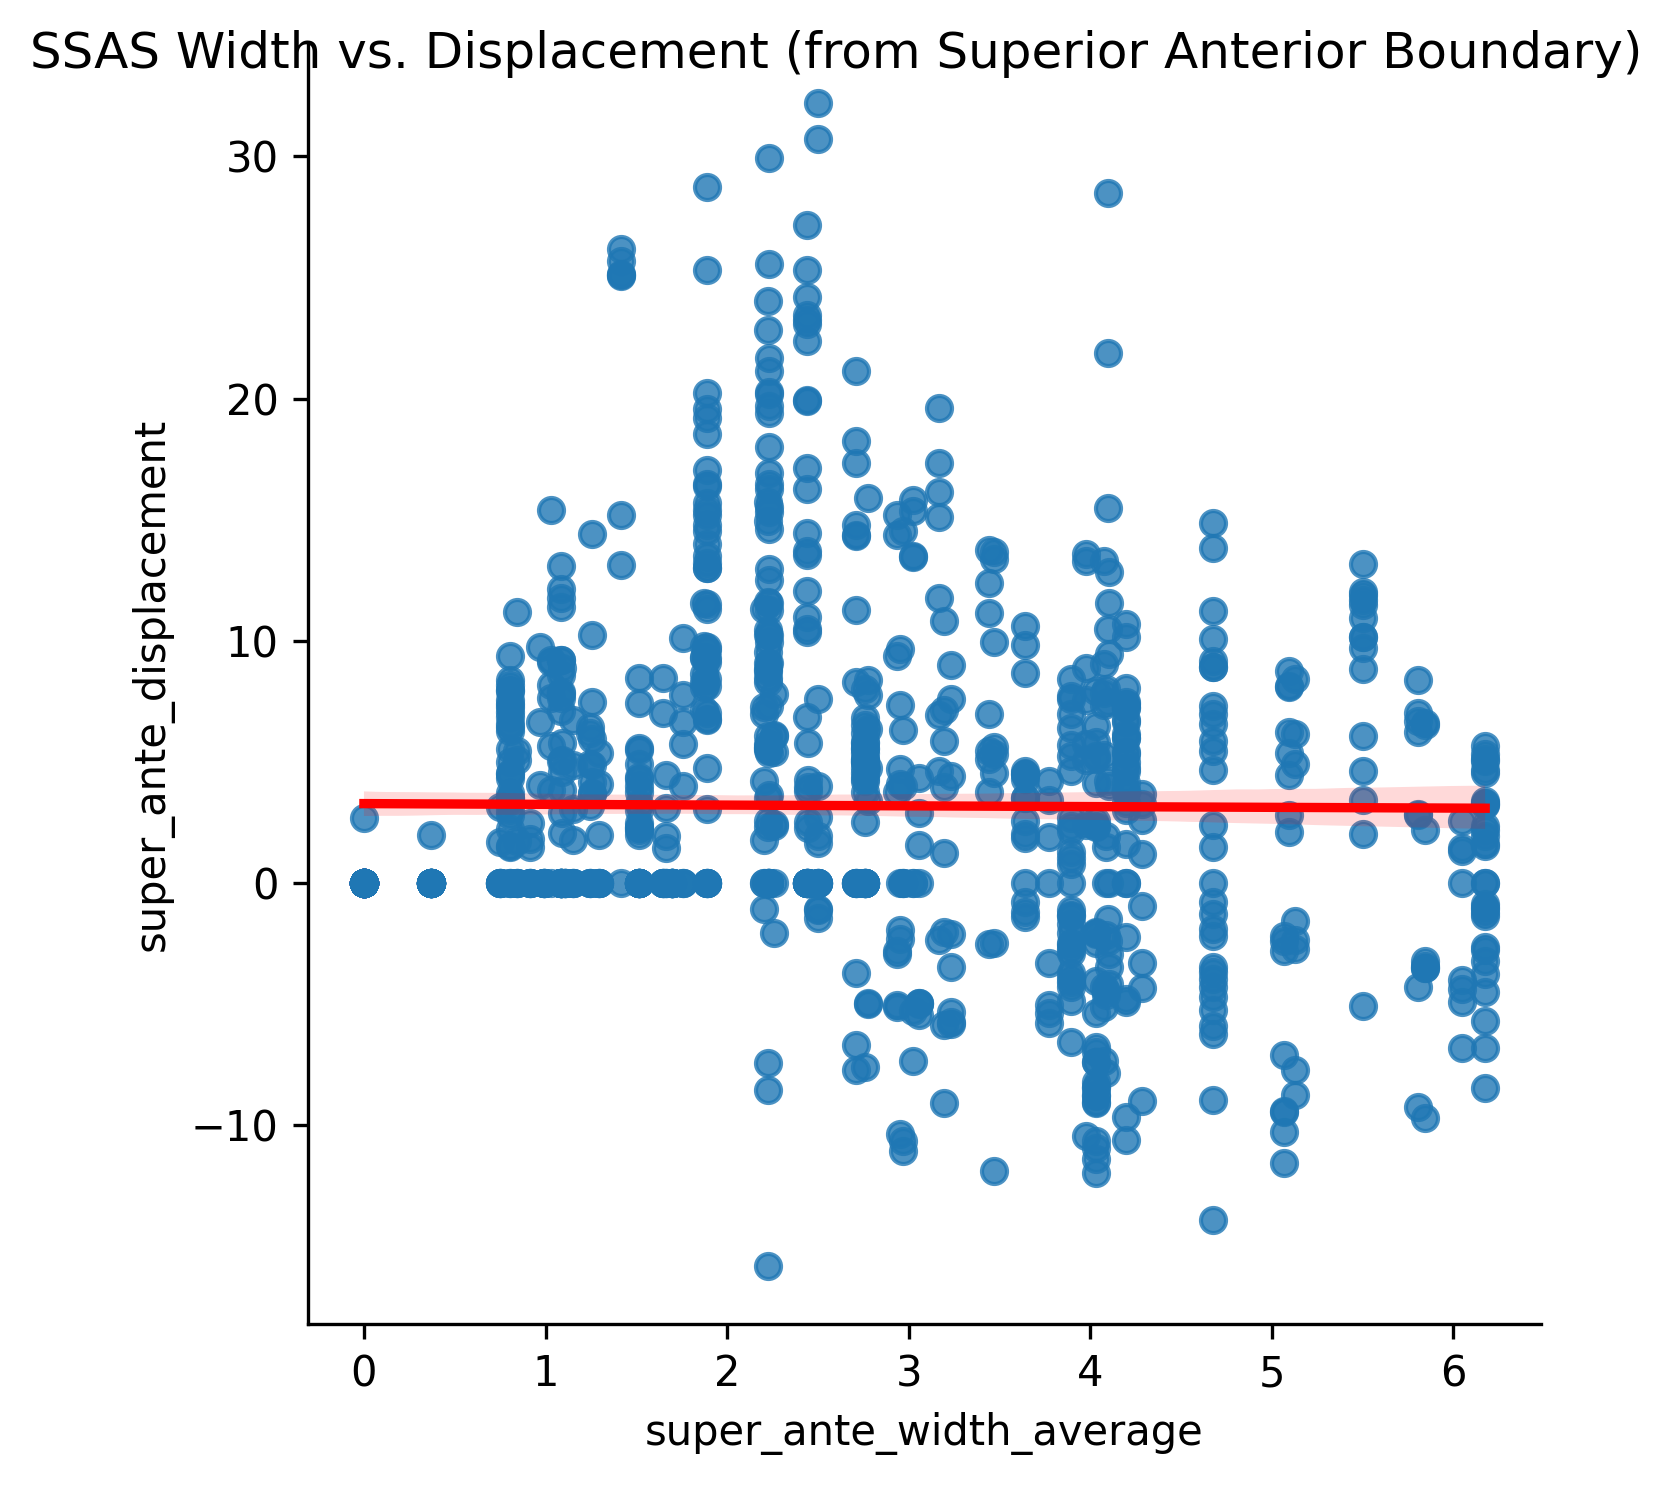

In [11]:
ax = seaborn.lmplot(x="super_ante_width_average", y="super_ante_displacement",
                    data=csf_flow_df, legend=True, line_kws={'color': 'red'})
ax.fig.suptitle("SSAS Width vs. Displacement (from Superior Anterior Boundary)")

In [12]:
# Remove columns that need to have real values (not NaN), or else the stats tests break
temp_df = csf_flow_df.copy()
columns_that_cant_be_nan = ['super_ante_width', 'super_ante_displacement'] 
temp_df = temp_df.dropna(subset=columns_that_cant_be_nan)

# Pearson Correlation
super_ante_pearson = stats.pearsonr(temp_df['super_ante_width_average'], temp_df['super_ante_displacement'])
super_ante_pearson

PearsonRResult(statistic=-0.00712758323448257, pvalue=0.821364016783874)

In [13]:
super_ante_pearson.confidence_interval()

ConfidenceInterval(low=-0.06890508313225764, high=0.054704371650848065)

### Superior Posterior Boundary

Text(0.5, 0.98, 'SSAS Width vs. Displacement (from Superior Posterior Boundary)')

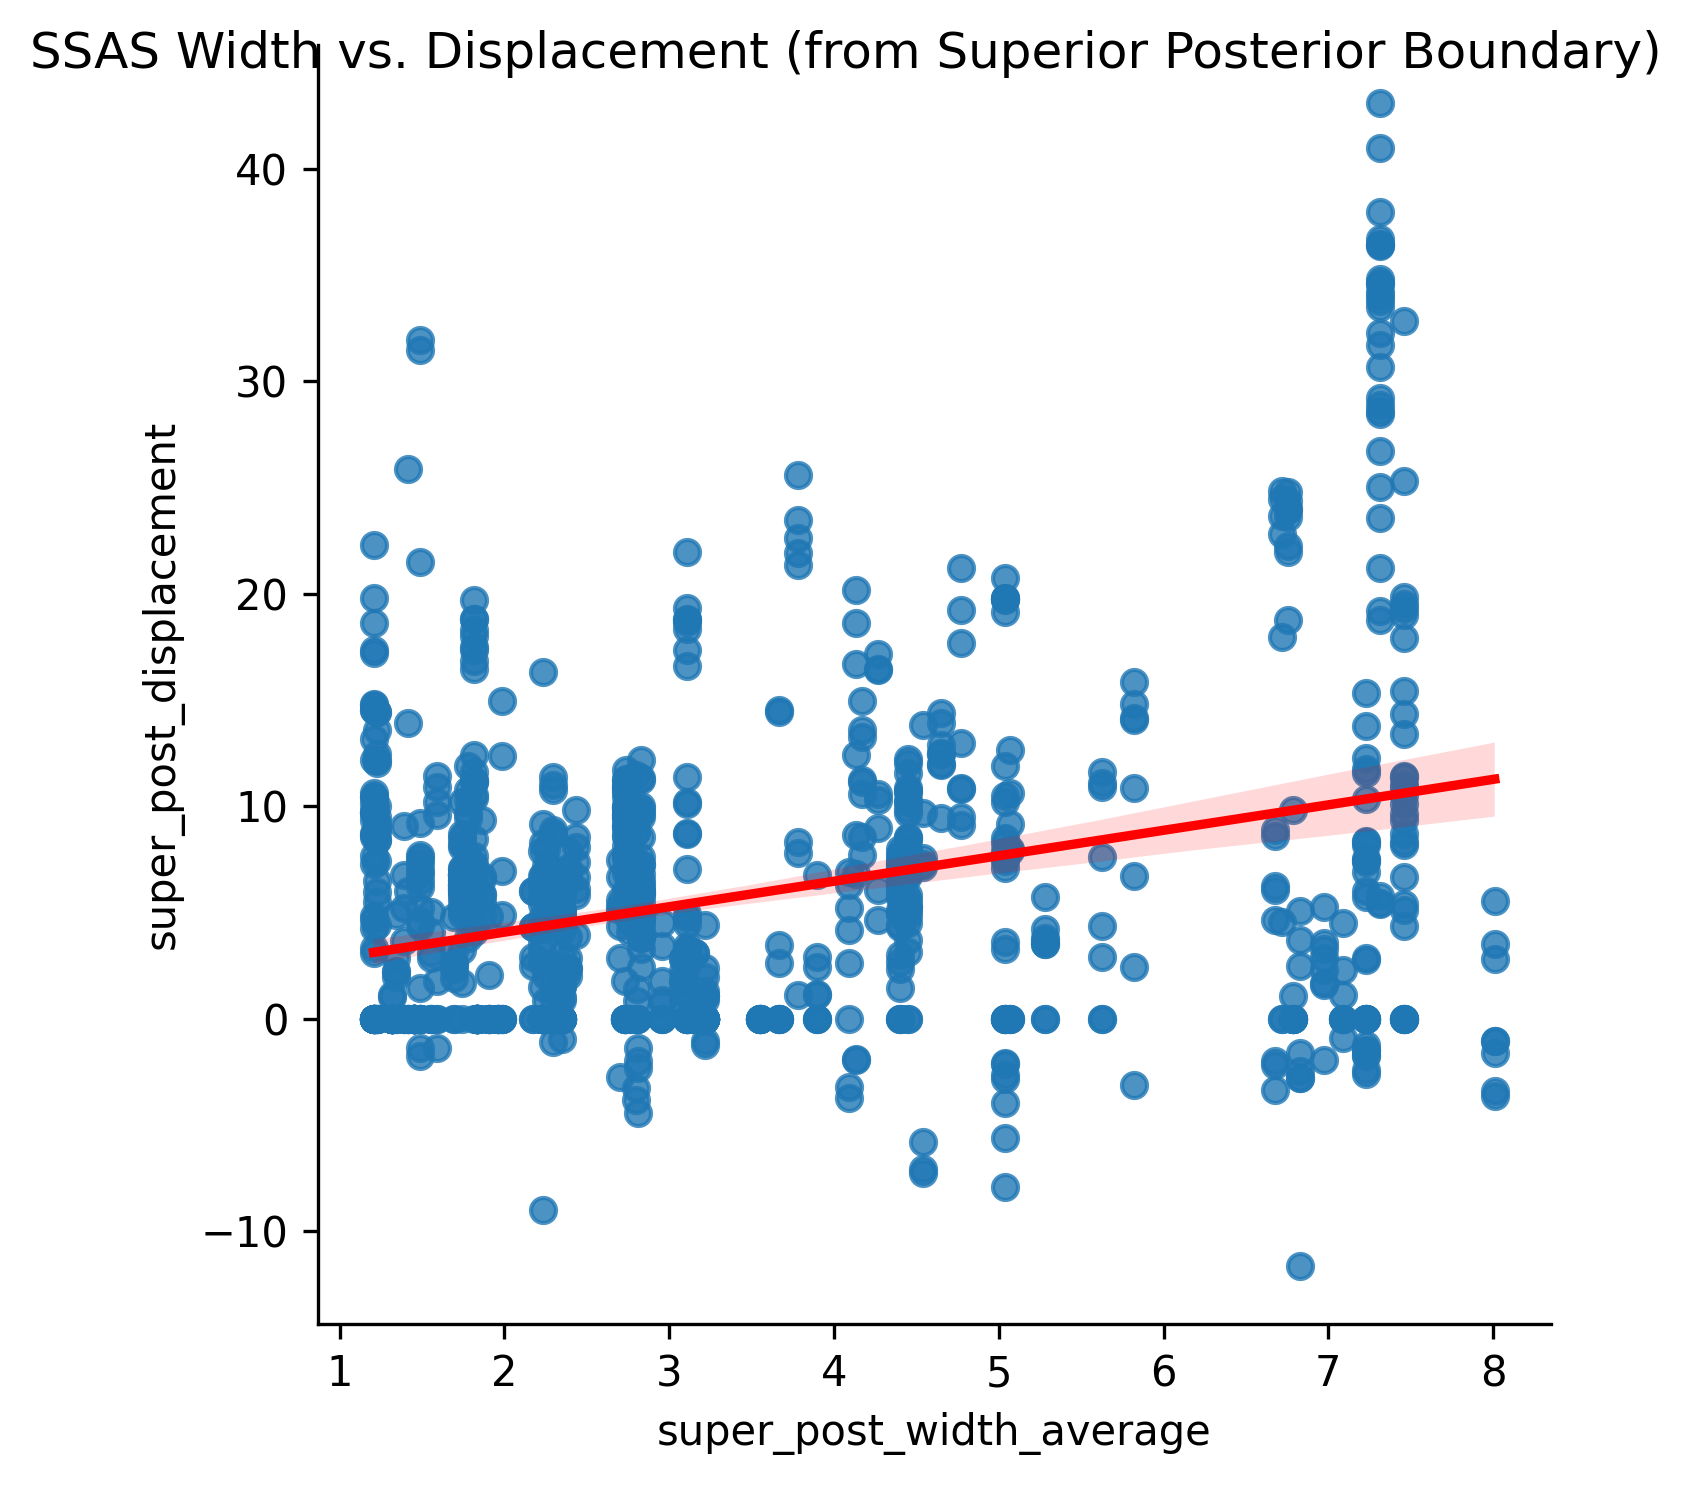

In [14]:
ax = seaborn.lmplot(x="super_post_width_average", y="super_post_displacement",
                    data=csf_flow_df, legend=True, line_kws={'color': 'red'})
ax.fig.suptitle("SSAS Width vs. Displacement (from Superior Posterior Boundary)")

In [15]:
# Remove columns that need to have real values (not NaN), or else the stats tests break
temp_df = csf_flow_df.copy()
columns_that_cant_be_nan = ['super_post_width_average', 'super_post_displacement'] 
temp_df = temp_df.dropna(subset=columns_that_cant_be_nan)

# Pearson Correlation
super_post_pearson = stats.pearsonr(temp_df['super_post_width_average'], temp_df['super_post_displacement'])
super_post_pearson

PearsonRResult(statistic=0.3147625146104876, pvalue=6.4525430783298515e-25)

In [16]:
super_post_pearson.confidence_interval()

ConfidenceInterval(low=0.2584006100380571, high=0.3689888176076503)

### Inferior Anterior Boundary

Text(0.5, 0.98, 'SSAS Width vs. Displacement (from Inferior Anterior Boundary)')

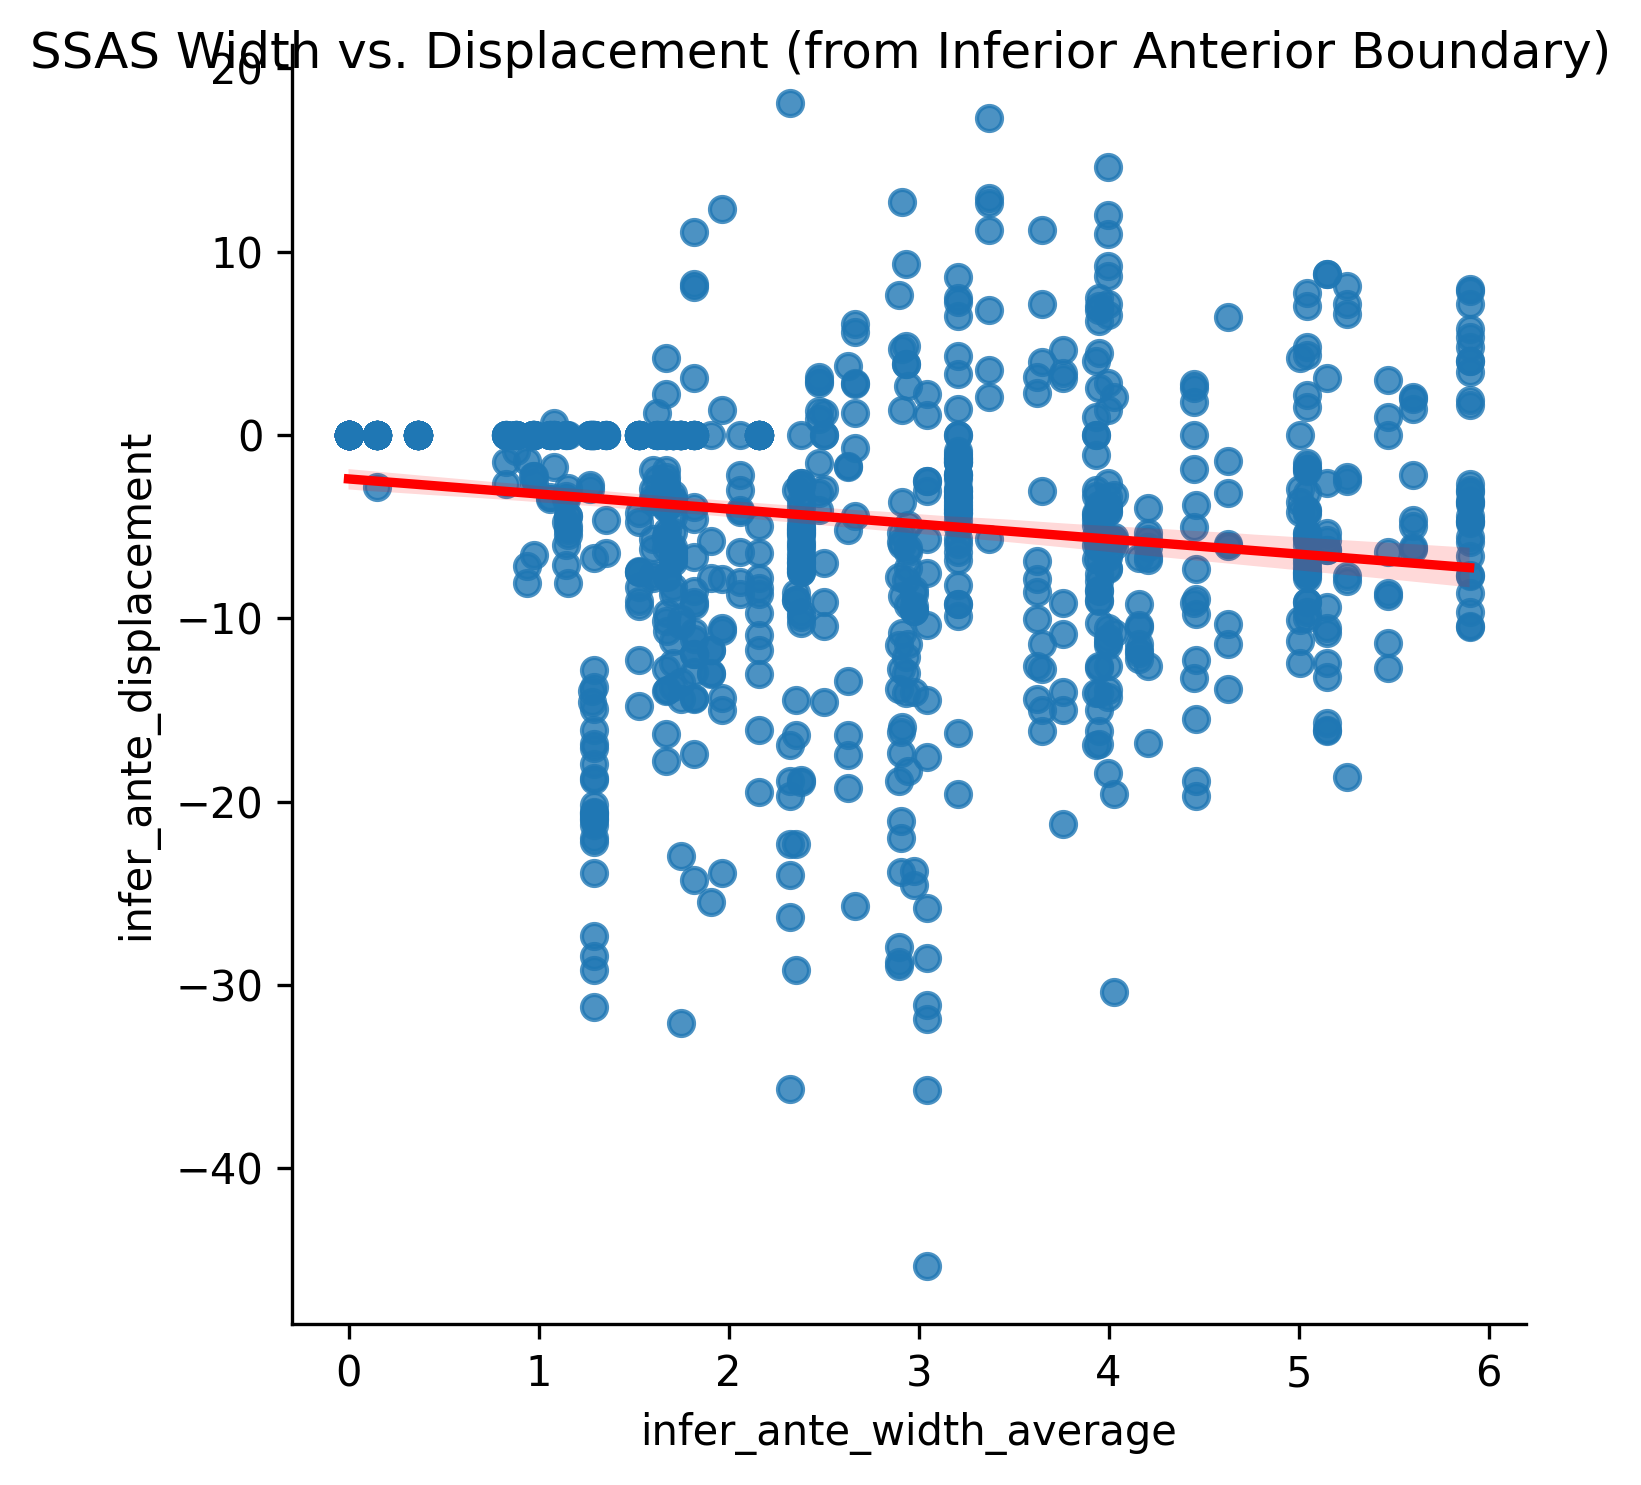

In [17]:
ax = seaborn.lmplot(x="infer_ante_width_average", y="infer_ante_displacement",
                    data=csf_flow_df, legend=True, line_kws={'color': 'red'})
ax.fig.suptitle("SSAS Width vs. Displacement (from Inferior Anterior Boundary)")

In [18]:
# Remove columns that need to have real values (not NaN), or else the stats tests break
temp_df = csf_flow_df.copy()
columns_that_cant_be_nan = ['infer_ante_width_average', 'infer_ante_displacement'] 
temp_df = temp_df.dropna(subset=columns_that_cant_be_nan)

# Pearson Correlation
infer_ante_pearson = stats.pearsonr(temp_df['infer_ante_width_average'], temp_df['infer_ante_displacement'])
infer_ante_pearson

PearsonRResult(statistic=-0.1861483141127834, pvalue=2.8504023117110783e-09)

In [19]:
infer_ante_pearson.confidence_interval()

ConfidenceInterval(low=-0.24522296192751766, high=-0.12569640611049318)

### Inferior Posterior Boundary

Text(0.5, 0.98, 'SSAS Width vs. Displacement (from Inferior Posterior Boundary)')

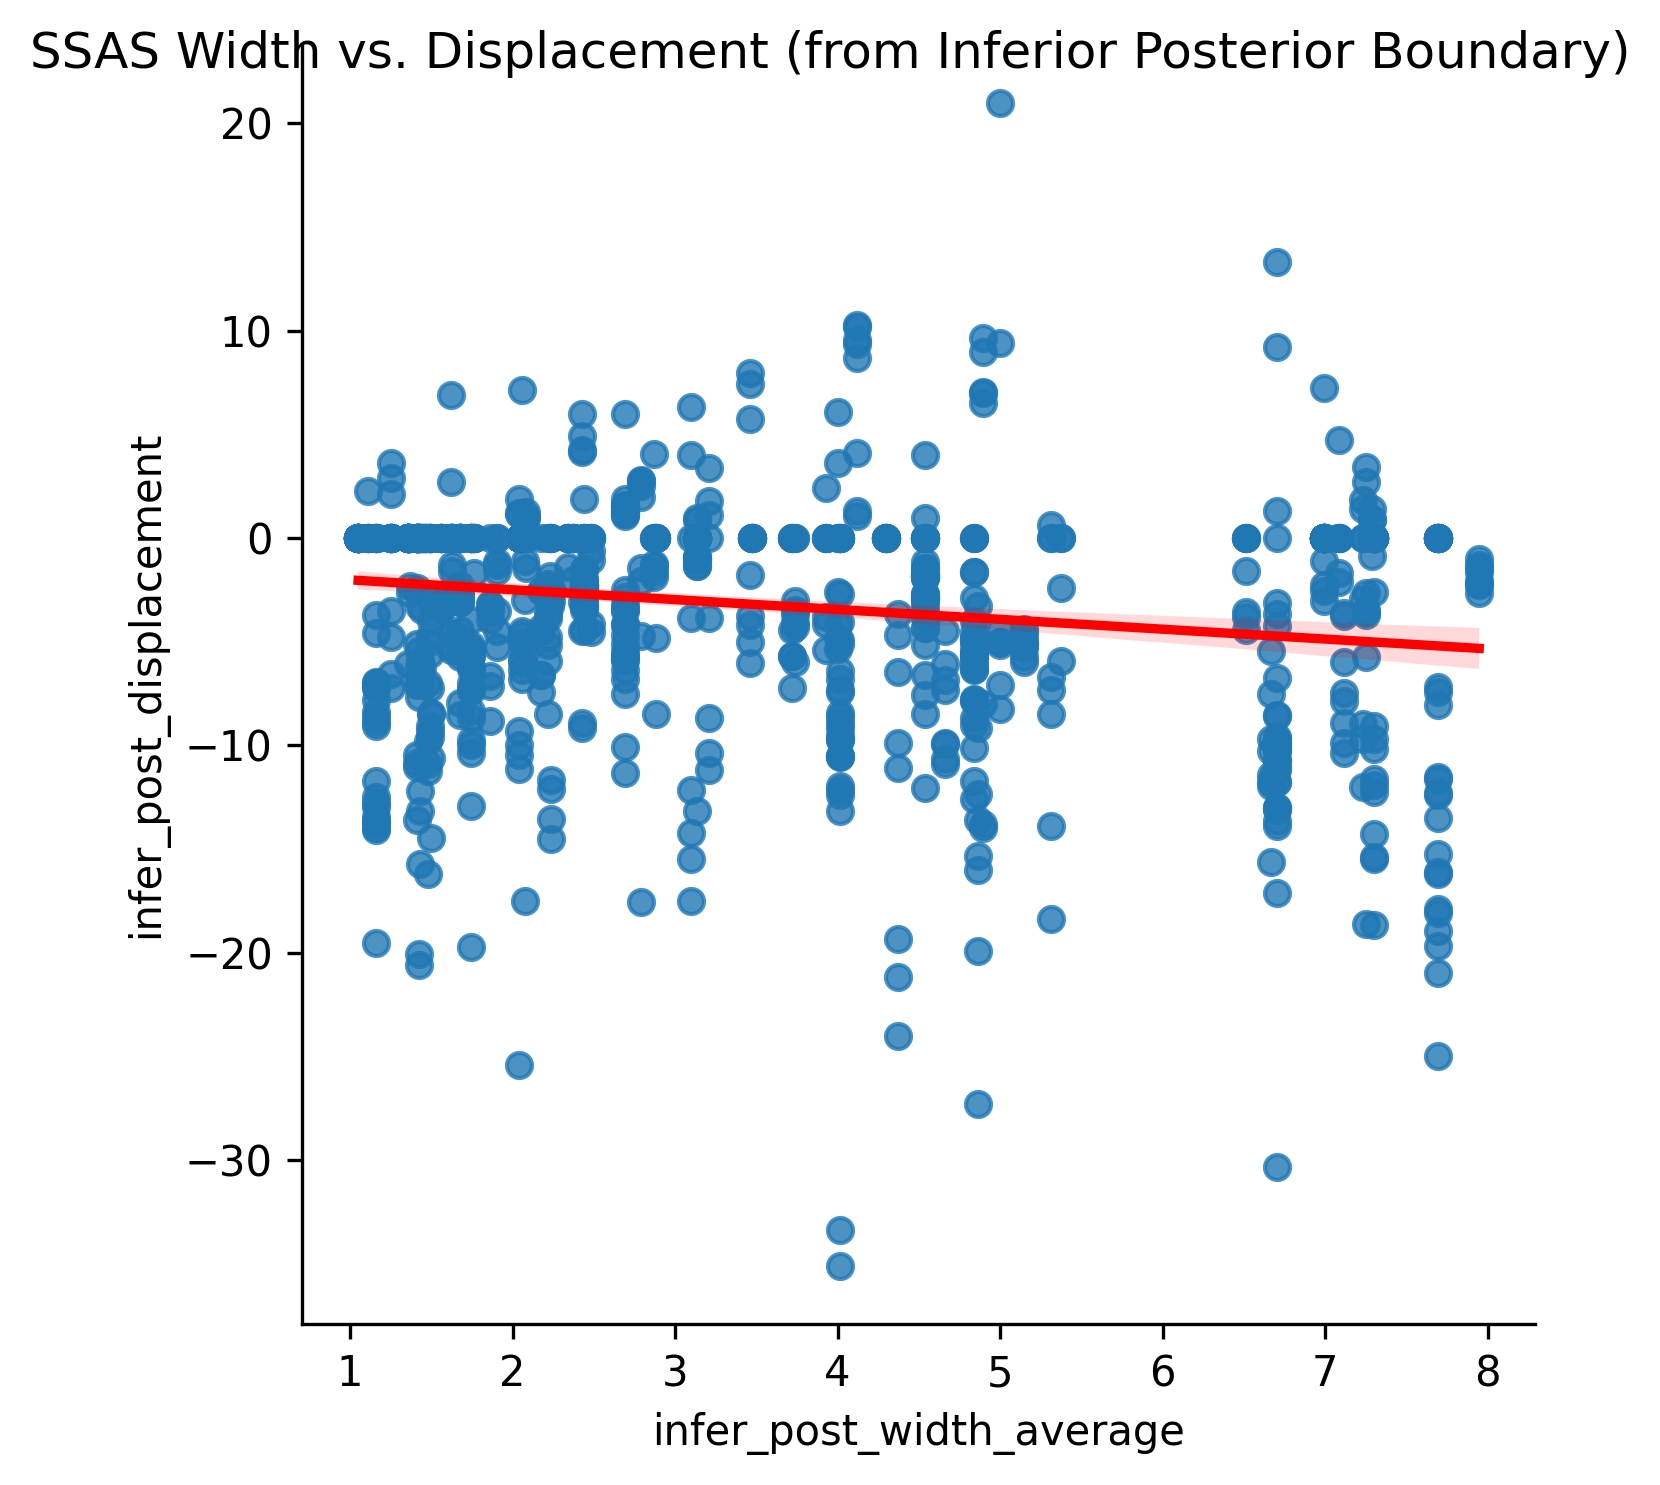

In [20]:
ax = seaborn.lmplot(x="infer_post_width_average", y="infer_post_displacement",
                    data=csf_flow_df, legend=True, line_kws={'color': 'red'})
ax.fig.suptitle("SSAS Width vs. Displacement (from Inferior Posterior Boundary)")

In [21]:
# Remove columns that need to have real values (not NaN), or else the stats tests break
temp_df = csf_flow_df.copy()
columns_that_cant_be_nan = ['infer_post_width_average', 'infer_post_displacement'] 
temp_df = temp_df.dropna(subset=columns_that_cant_be_nan)

# Pearson Correlation
infer_post_pearson = stats.pearsonr(temp_df['infer_post_width_average'], temp_df['infer_post_displacement'])
infer_post_pearson

PearsonRResult(statistic=-0.1821570579865153, pvalue=4.887971177415331e-09)

In [22]:
infer_post_pearson.confidence_interval()

ConfidenceInterval(low=-0.24093172840607477, high=-0.12205120419989725)

### All Boundaries

In [23]:
# Combine all width-displacement combos into a two-column dataframe
super_ante_df = csf_flow_df[['super_ante_width_average', 'super_ante_displacement']]
super_post_df = csf_flow_df[['super_post_width_average', 'super_post_displacement']]
infer_ante_df = csf_flow_df[['infer_ante_width_average', 'infer_ante_displacement']]
infer_post_df = csf_flow_df[['infer_post_width_average', 'infer_post_displacement']]

# Rename columns for easier combination of dataframes
super_ante_df.columns = ['width', 'displacement']
super_post_df.columns = ['width', 'displacement']
infer_ante_df.columns = ['width', 'displacement']
infer_post_df.columns = ['width', 'displacement']

In [24]:
# Stack all displacement measurements into one 2-column dataframe
all_measurements = pd.concat([super_ante_df, super_post_df, infer_ante_df, infer_post_df], 
                                             ignore_index=True)
all_measurements.head(3)

width  displacement
0  4.284875        -3.290
1  4.284875         3.676
2  4.284875        -4.330

Text(0.5, 0.98, 'SSAS Width vs. Displacement (All Measurements)')

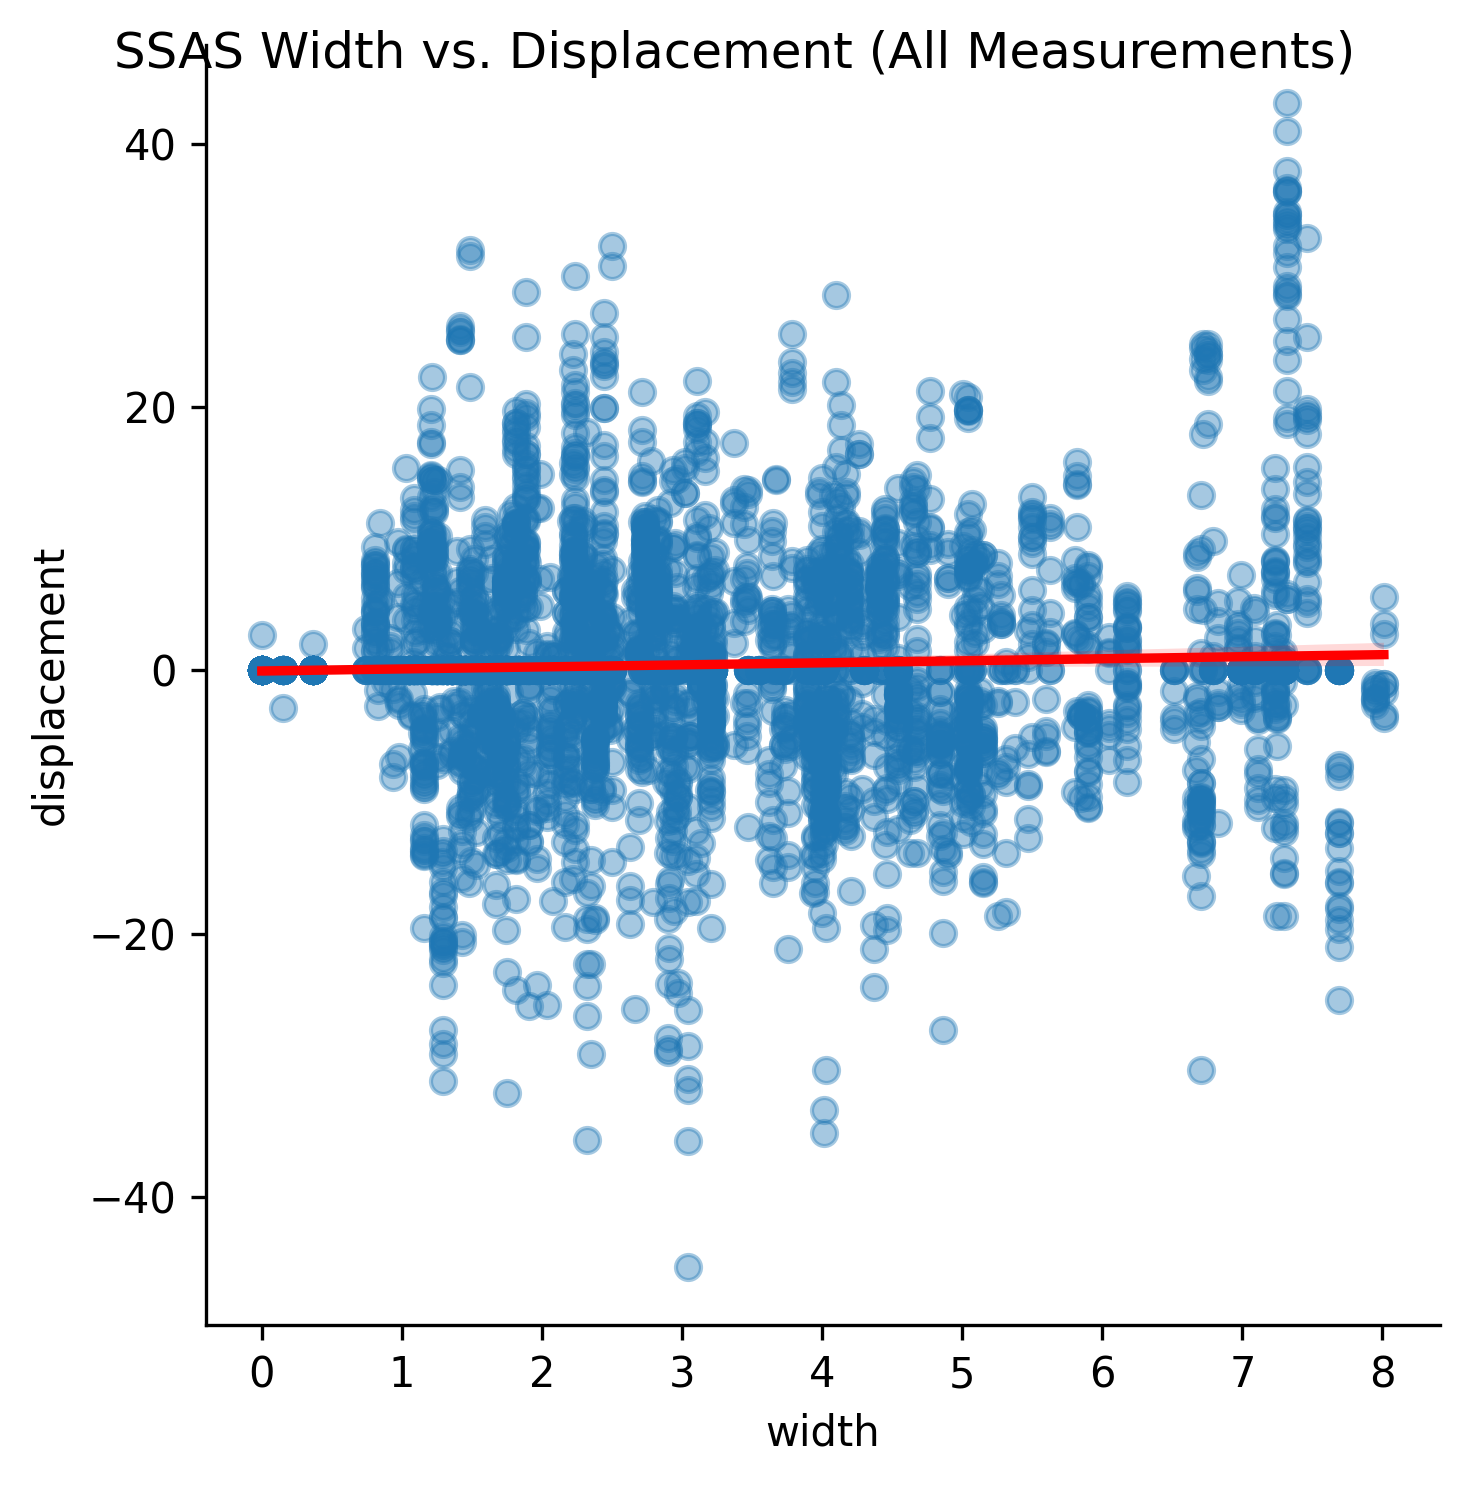

In [25]:
ax = seaborn.lmplot(x="width", y="displacement",
                    data=all_measurements, legend=True, 
                    line_kws={'color': 'red'}, scatter_kws={'alpha': 0.4})
ax.fig.suptitle("SSAS Width vs. Displacement (All Measurements)")

In [26]:
# Remove columns that need to have real values (not NaN), or else the stats tests break
temp_df = all_measurements.copy()
columns_that_cant_be_nan = ['width', 'displacement'] 
temp_df = temp_df.dropna(subset=columns_that_cant_be_nan)

# Pearson Correlation
all_measurements_pearson = stats.pearsonr(temp_df['width'], temp_df['displacement'])
all_measurements_pearson

PearsonRResult(statistic=0.03780555082209743, pvalue=0.0161261484577864)

In [27]:
all_measurements_pearson.confidence_interval()

ConfidenceInterval(low=0.0070141868466119354, high=0.06852529168268913)

In [28]:
# Remove NaN rows
all_measurements.dropna(inplace=True)

Linear Regression equation: y = 0.15493038328989134x + -0.04848093548599695


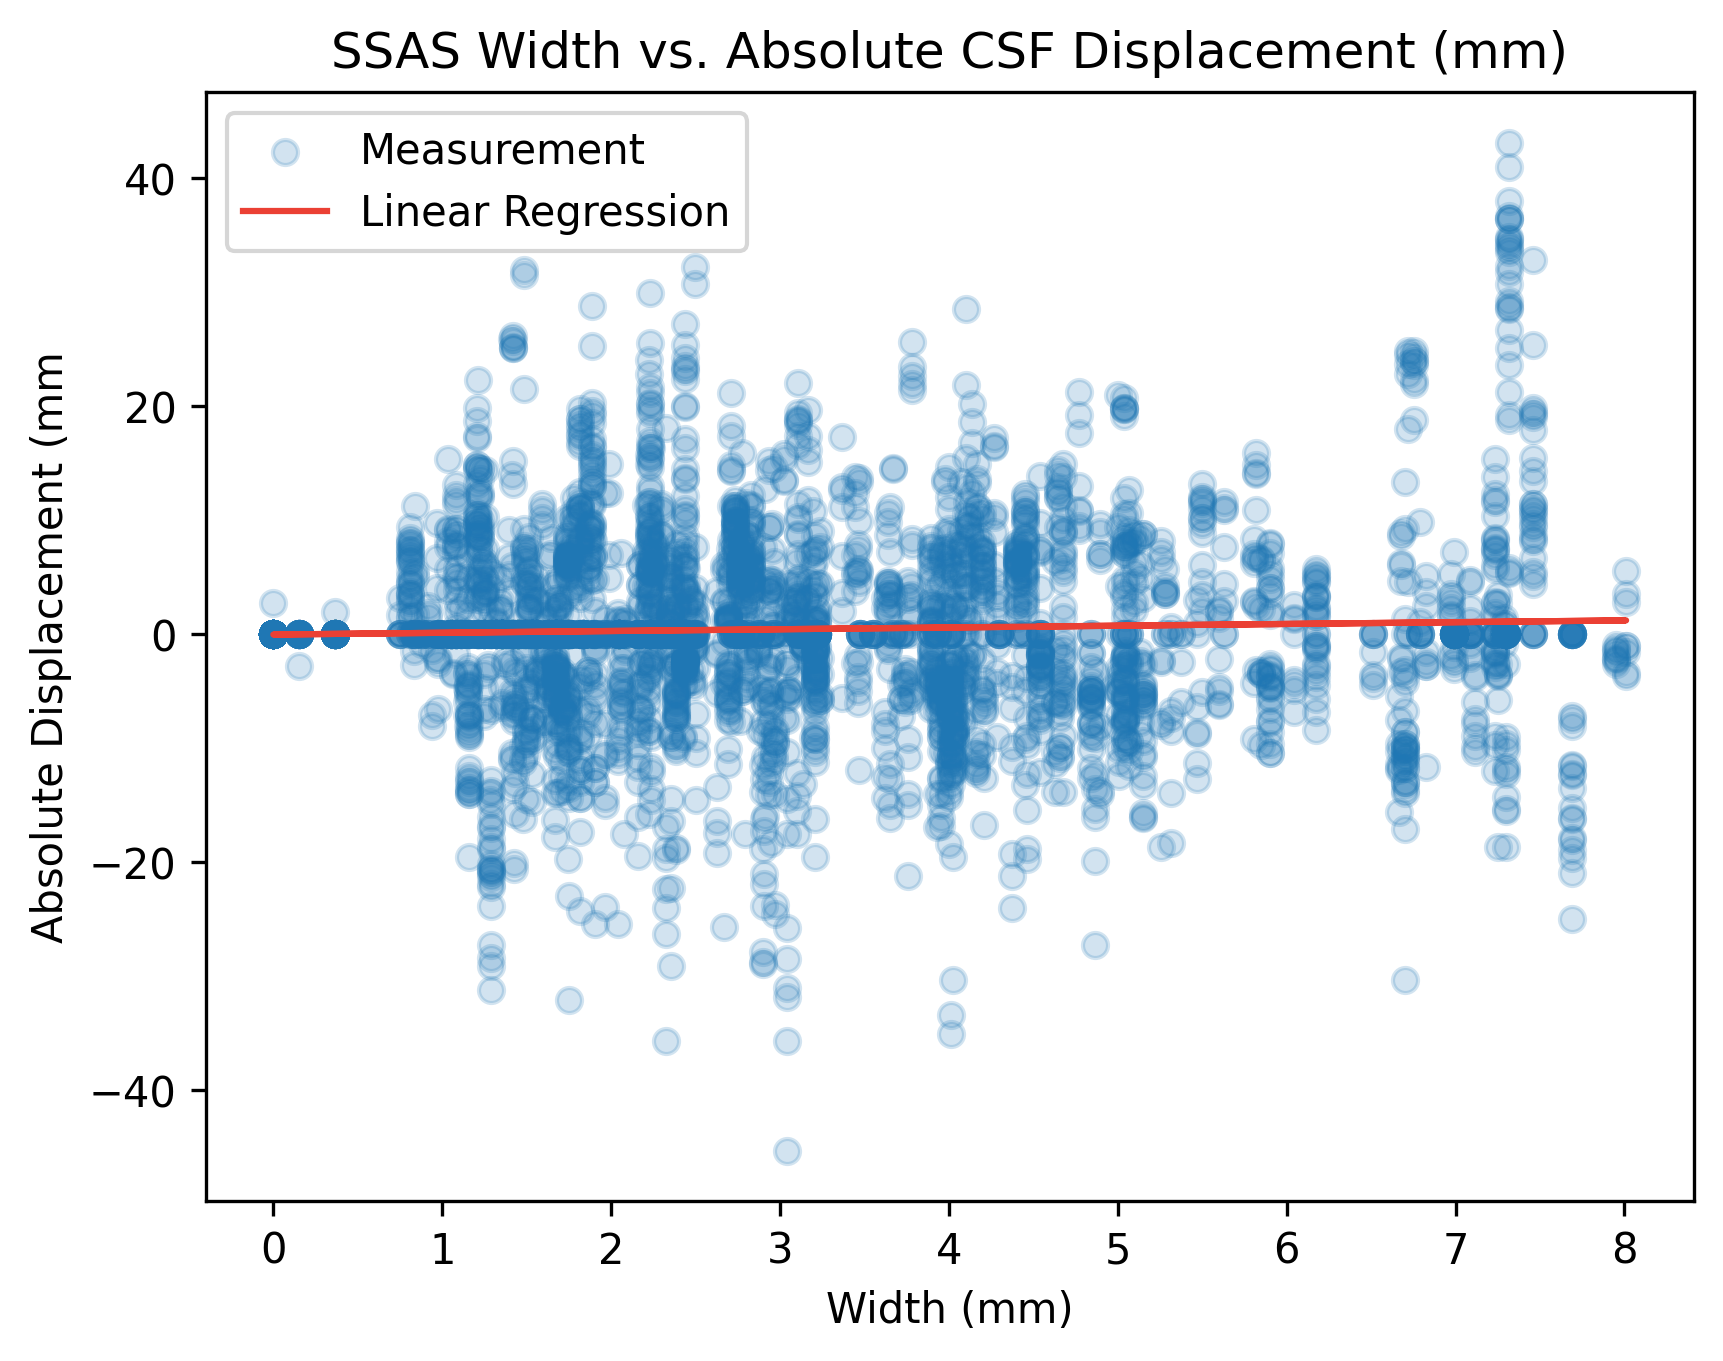

In [29]:
# Create scatter plot with linear regression
x = all_measurements['width']
y = all_measurements['displacement']

# Linear regression
m, b = np.polyfit(x, y, deg=1)

plt.scatter(x, y, alpha=0.2, label='Measurement')
plt.plot(x, m*x + b, color='#eb4034', label='Linear Regression')
plt.title('SSAS Width vs. Absolute CSF Displacement (mm)')
plt.xlabel('Width (mm)')
plt.ylabel('Absolute Displacement (mm')
plt.legend()
print(f'Linear Regression equation: y = {m}x + {b}')

In [30]:
x1 = pd.DataFrame(all_measurements['width'])
y1 = pd.DataFrame(all_measurements['displacement'])

# Add a constant to the independent variable
x_ = sm.add_constant(x1)

# Fit the linear regression model
model = sm.OLS(y1, x_)
results = model.fit()

# Calculate the confidence intervals
conf_int = results.conf_int(alpha=0.05) # 95% confidence interval

# Print the results
print(conf_int)

              0         1
const -0.485530  0.388569
width  0.028739  0.281121


# SSAS Width vs. CSF Flow Correlation (Absolute Value of Displacement)

These are the same analyses and graphs as the previous section, but with all displacement values as their absolute values, in order to analyze the magnitude of CSF displacement without directionality muddying the correlation.

### Superior Anterior Boundary (Absolute)

Text(0.5, 0.98, 'SSAS Width vs. Absolute Displacement (from Superior Anterior Boundary)')

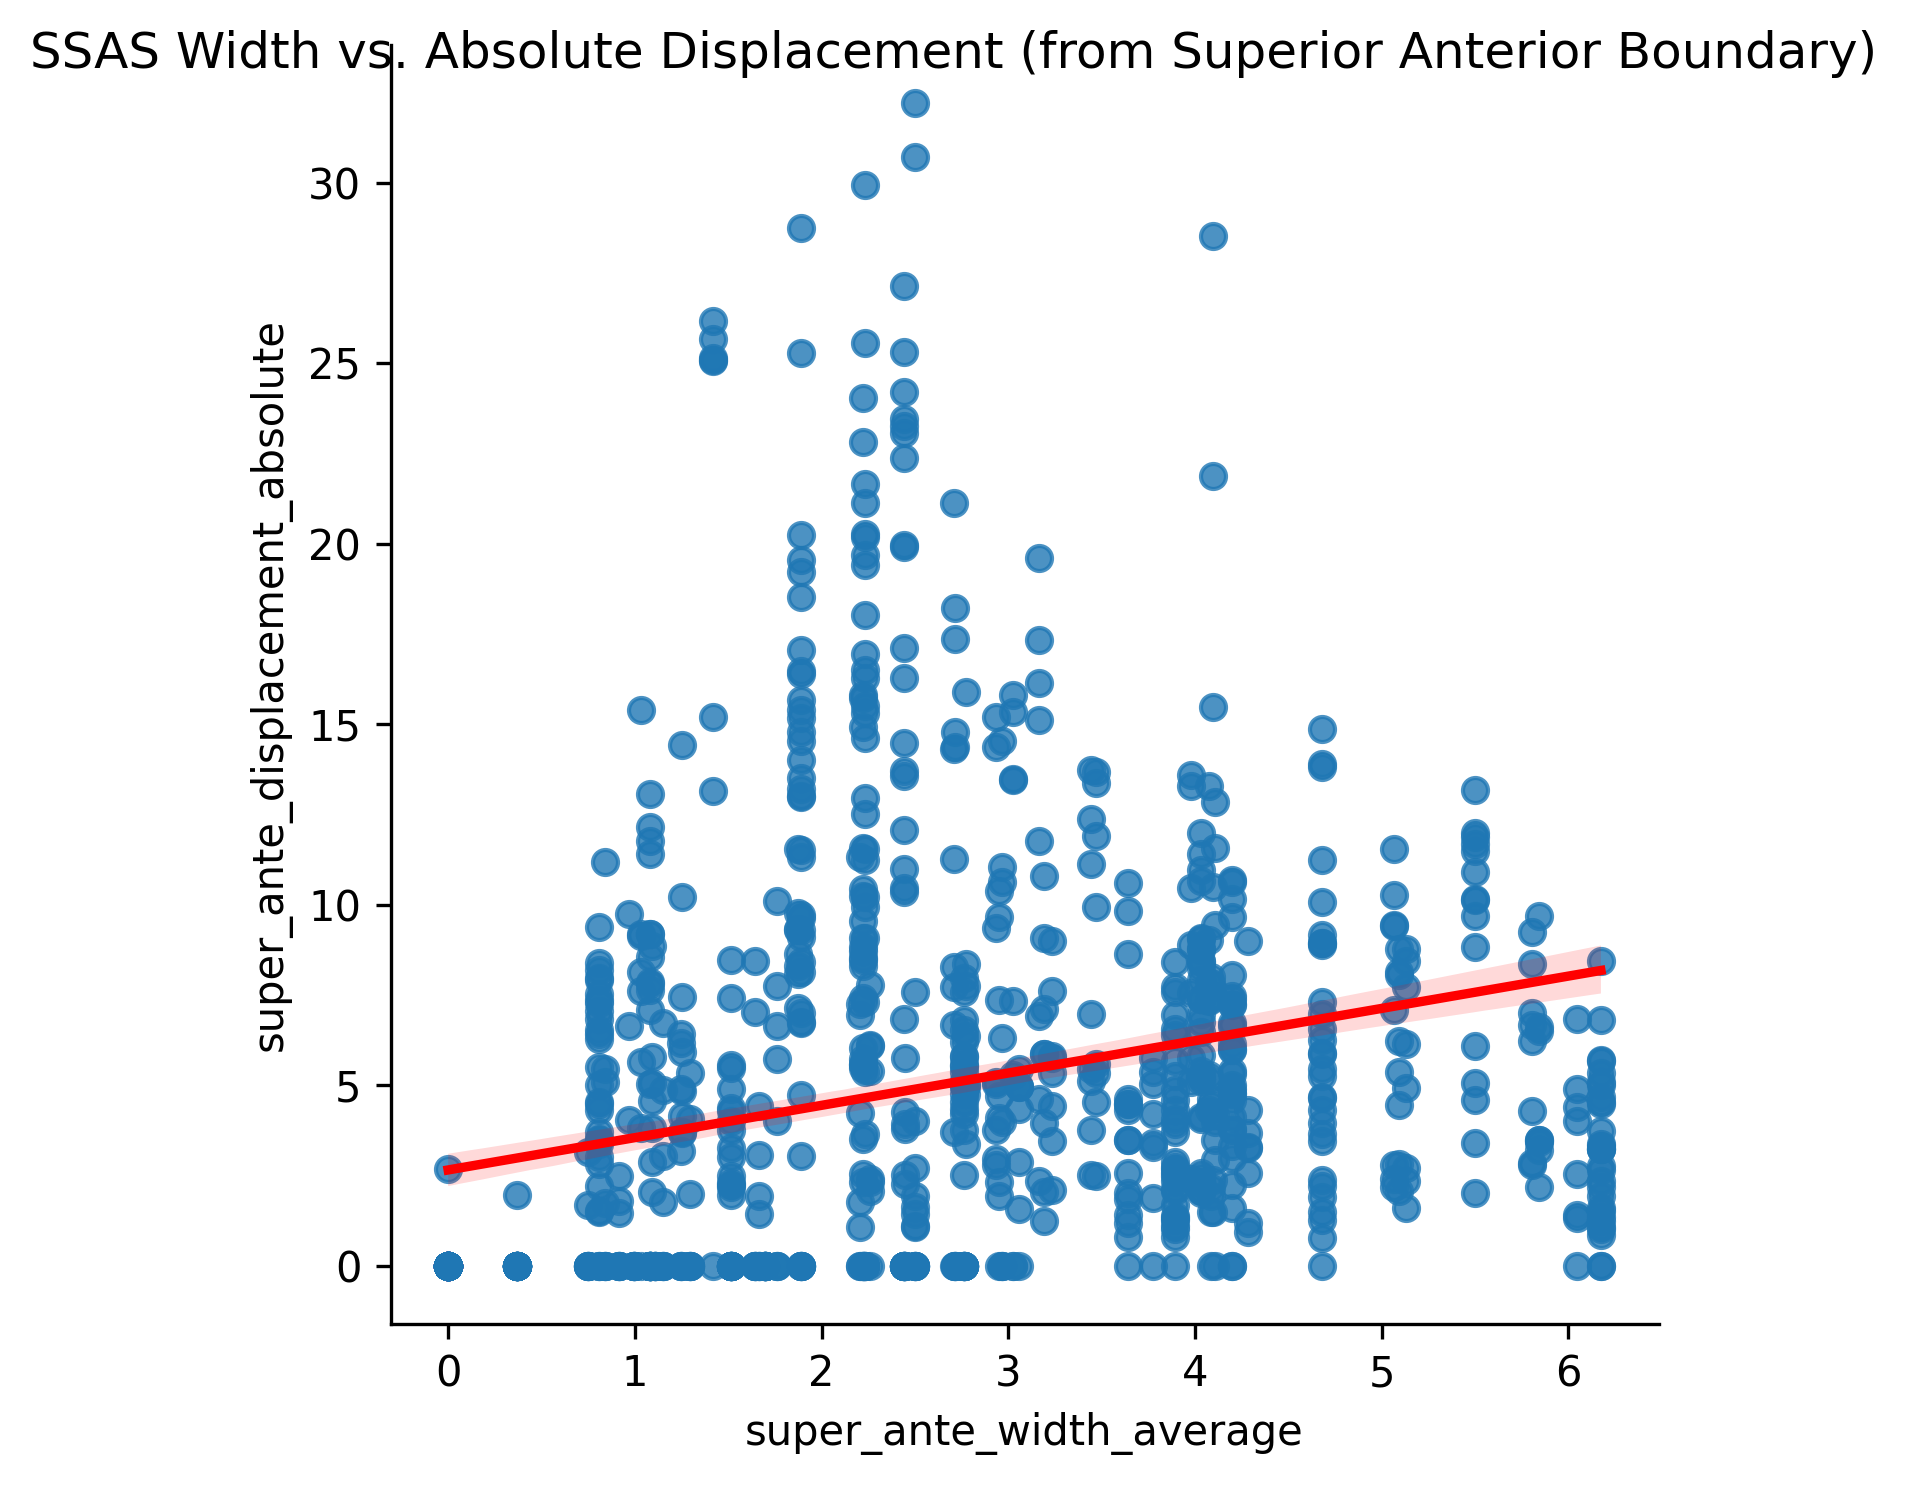

In [31]:
ax = seaborn.lmplot(x="super_ante_width_average", y="super_ante_displacement_absolute",
                    data=csf_flow_df, legend=True, line_kws={'color': 'red'})
ax.fig.suptitle("SSAS Width vs. Absolute Displacement (from Superior Anterior Boundary)")

In [32]:
# Remove columns that need to have real values (not NaN), or else the stats tests break
temp_df = csf_flow_df.copy()
columns_that_cant_be_nan = ['super_ante_width_average', 'super_ante_displacement_absolute'] 
temp_df = temp_df.dropna(subset=columns_that_cant_be_nan)

# Pearson Correlation
super_ante_pearson_abs = stats.pearsonr(temp_df['super_ante_width_average'], temp_df['super_ante_displacement_absolute'])
super_ante_pearson_abs

PearsonRResult(statistic=0.27205384607320027, pvalue=1.399352185666543e-18)

In [33]:
super_ante_pearson_abs.confidence_interval()

ConfidenceInterval(low=0.21392987444193357, high=0.32825824013440125)

### Superior Posterior Boundary (Absolute)

Text(0.5, 0.98, 'SSAS Width vs. Absolute Displacement (from Superior Posterior Boundary)')

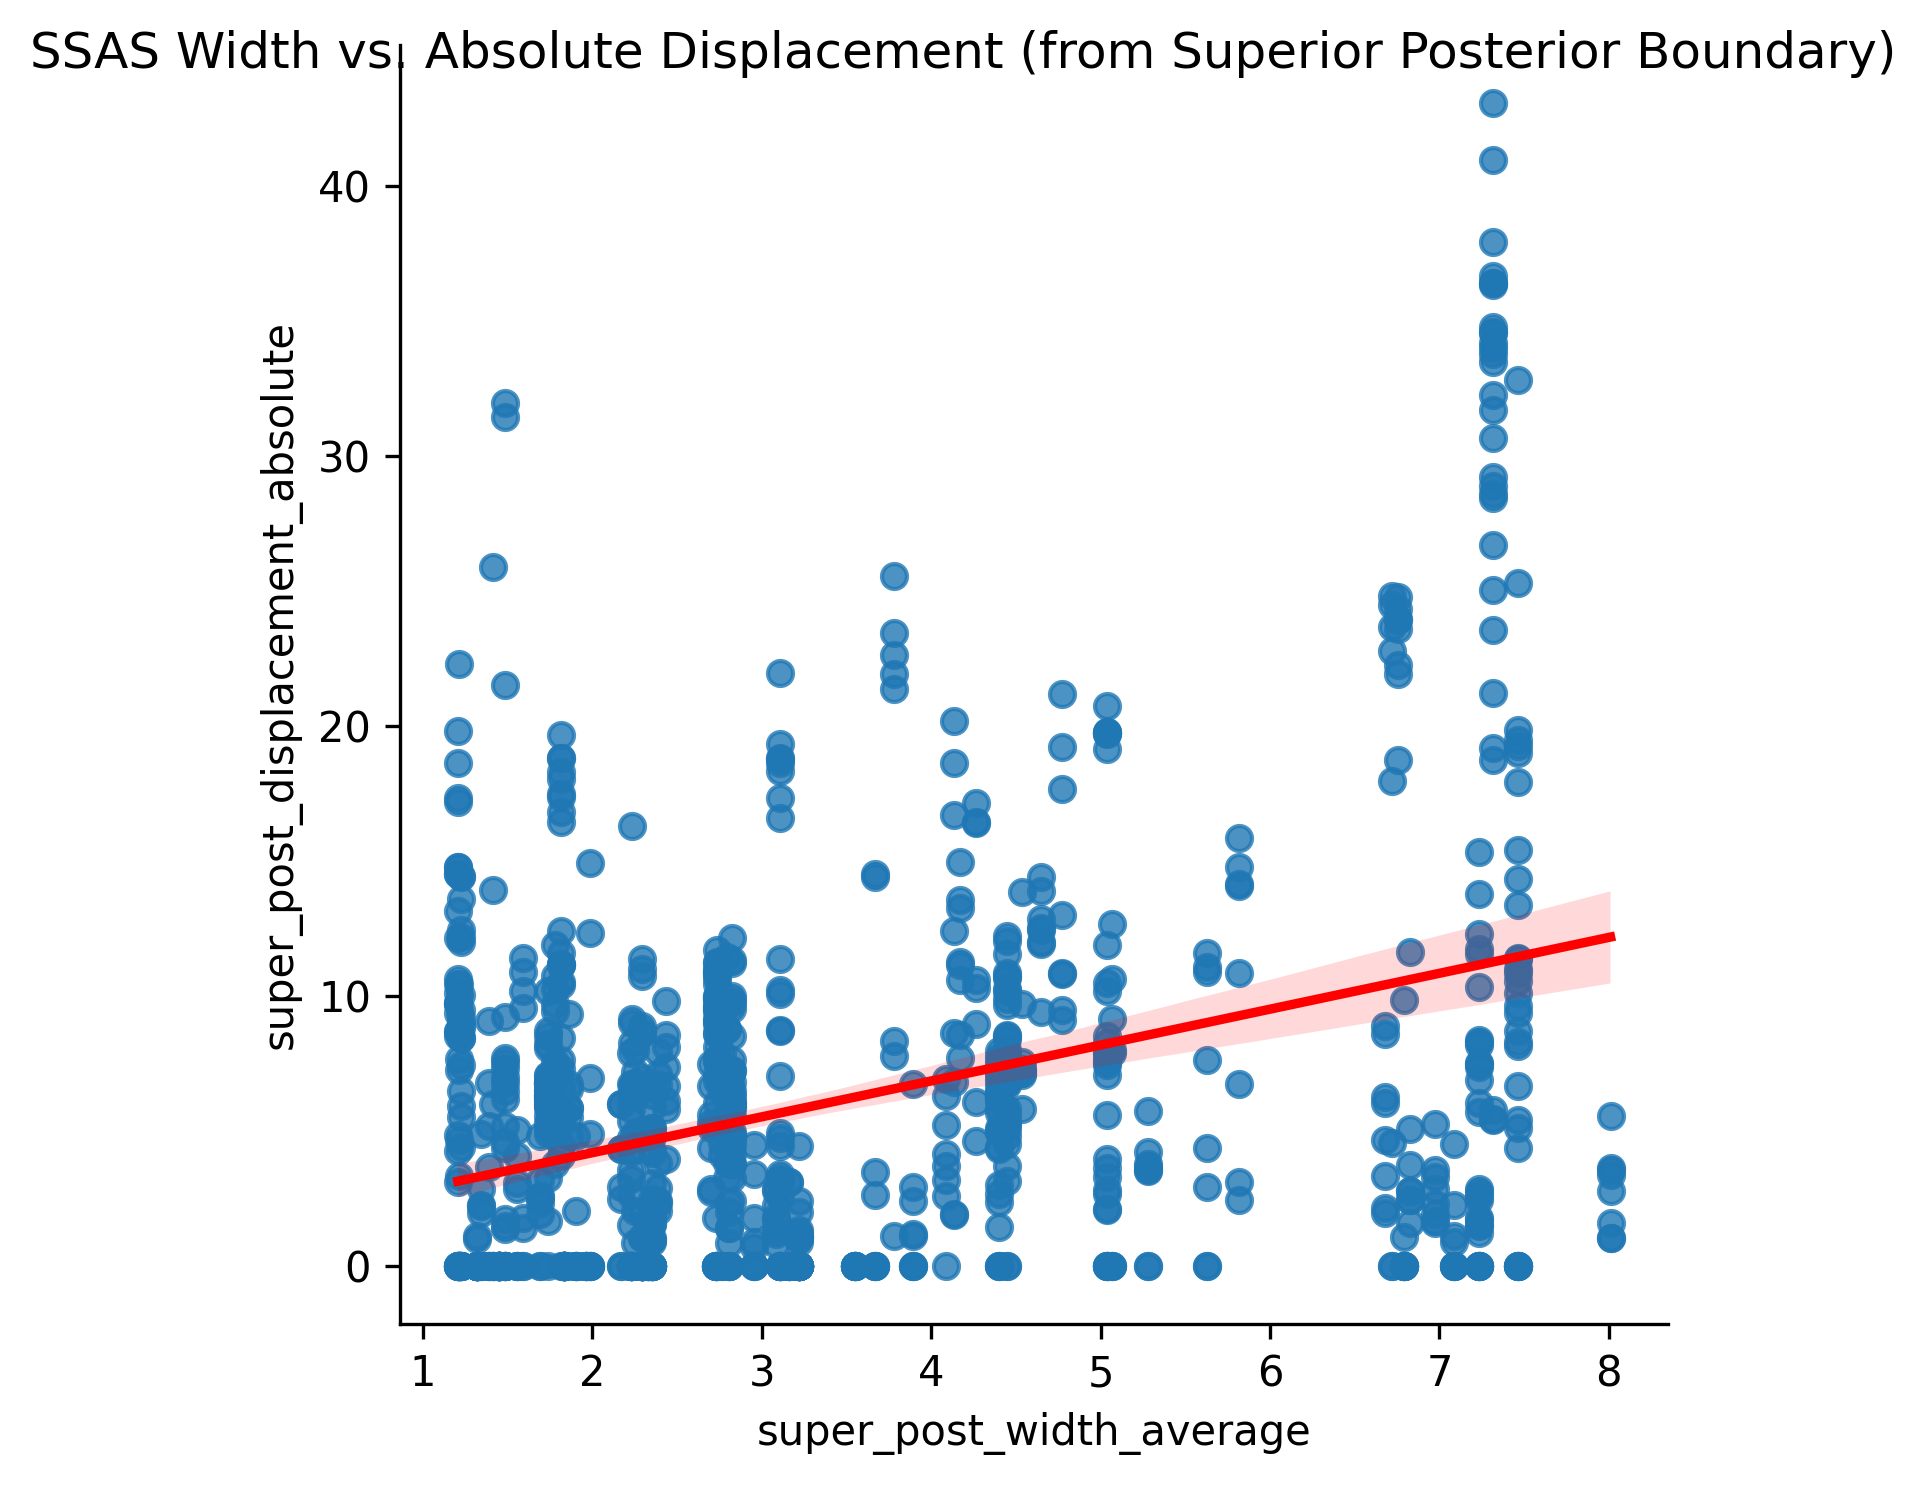

In [34]:
ax = seaborn.lmplot(x="super_post_width_average", y="super_post_displacement_absolute",
                    data=csf_flow_df, legend=True, line_kws={'color': 'red'})
ax.fig.suptitle("SSAS Width vs. Absolute Displacement (from Superior Posterior Boundary)")

In [35]:
# Remove columns that need to have real values (not NaN), or else the stats tests break
temp_df = csf_flow_df.copy()
columns_that_cant_be_nan = ['super_post_width_average', 'super_post_displacement_absolute'] 
temp_df = temp_df.dropna(subset=columns_that_cant_be_nan)

# Pearson Correlation
super_post_pearson_abs = stats.pearsonr(temp_df['super_post_width_average'], temp_df['super_post_displacement_absolute'])
super_post_pearson_abs

PearsonRResult(statistic=0.36091256944462563, pvalue=9.057524956440573e-33)

In [36]:
super_post_pearson_abs.confidence_interval()

ConfidenceInterval(low=0.30634389268061557, high=0.4131170021555433)

### Inferior Anterior Boundary (Absolute)

Text(0.5, 0.98, 'SSAS Width vs. Absolute Displacement (from Inferior Anterior Boundary)')

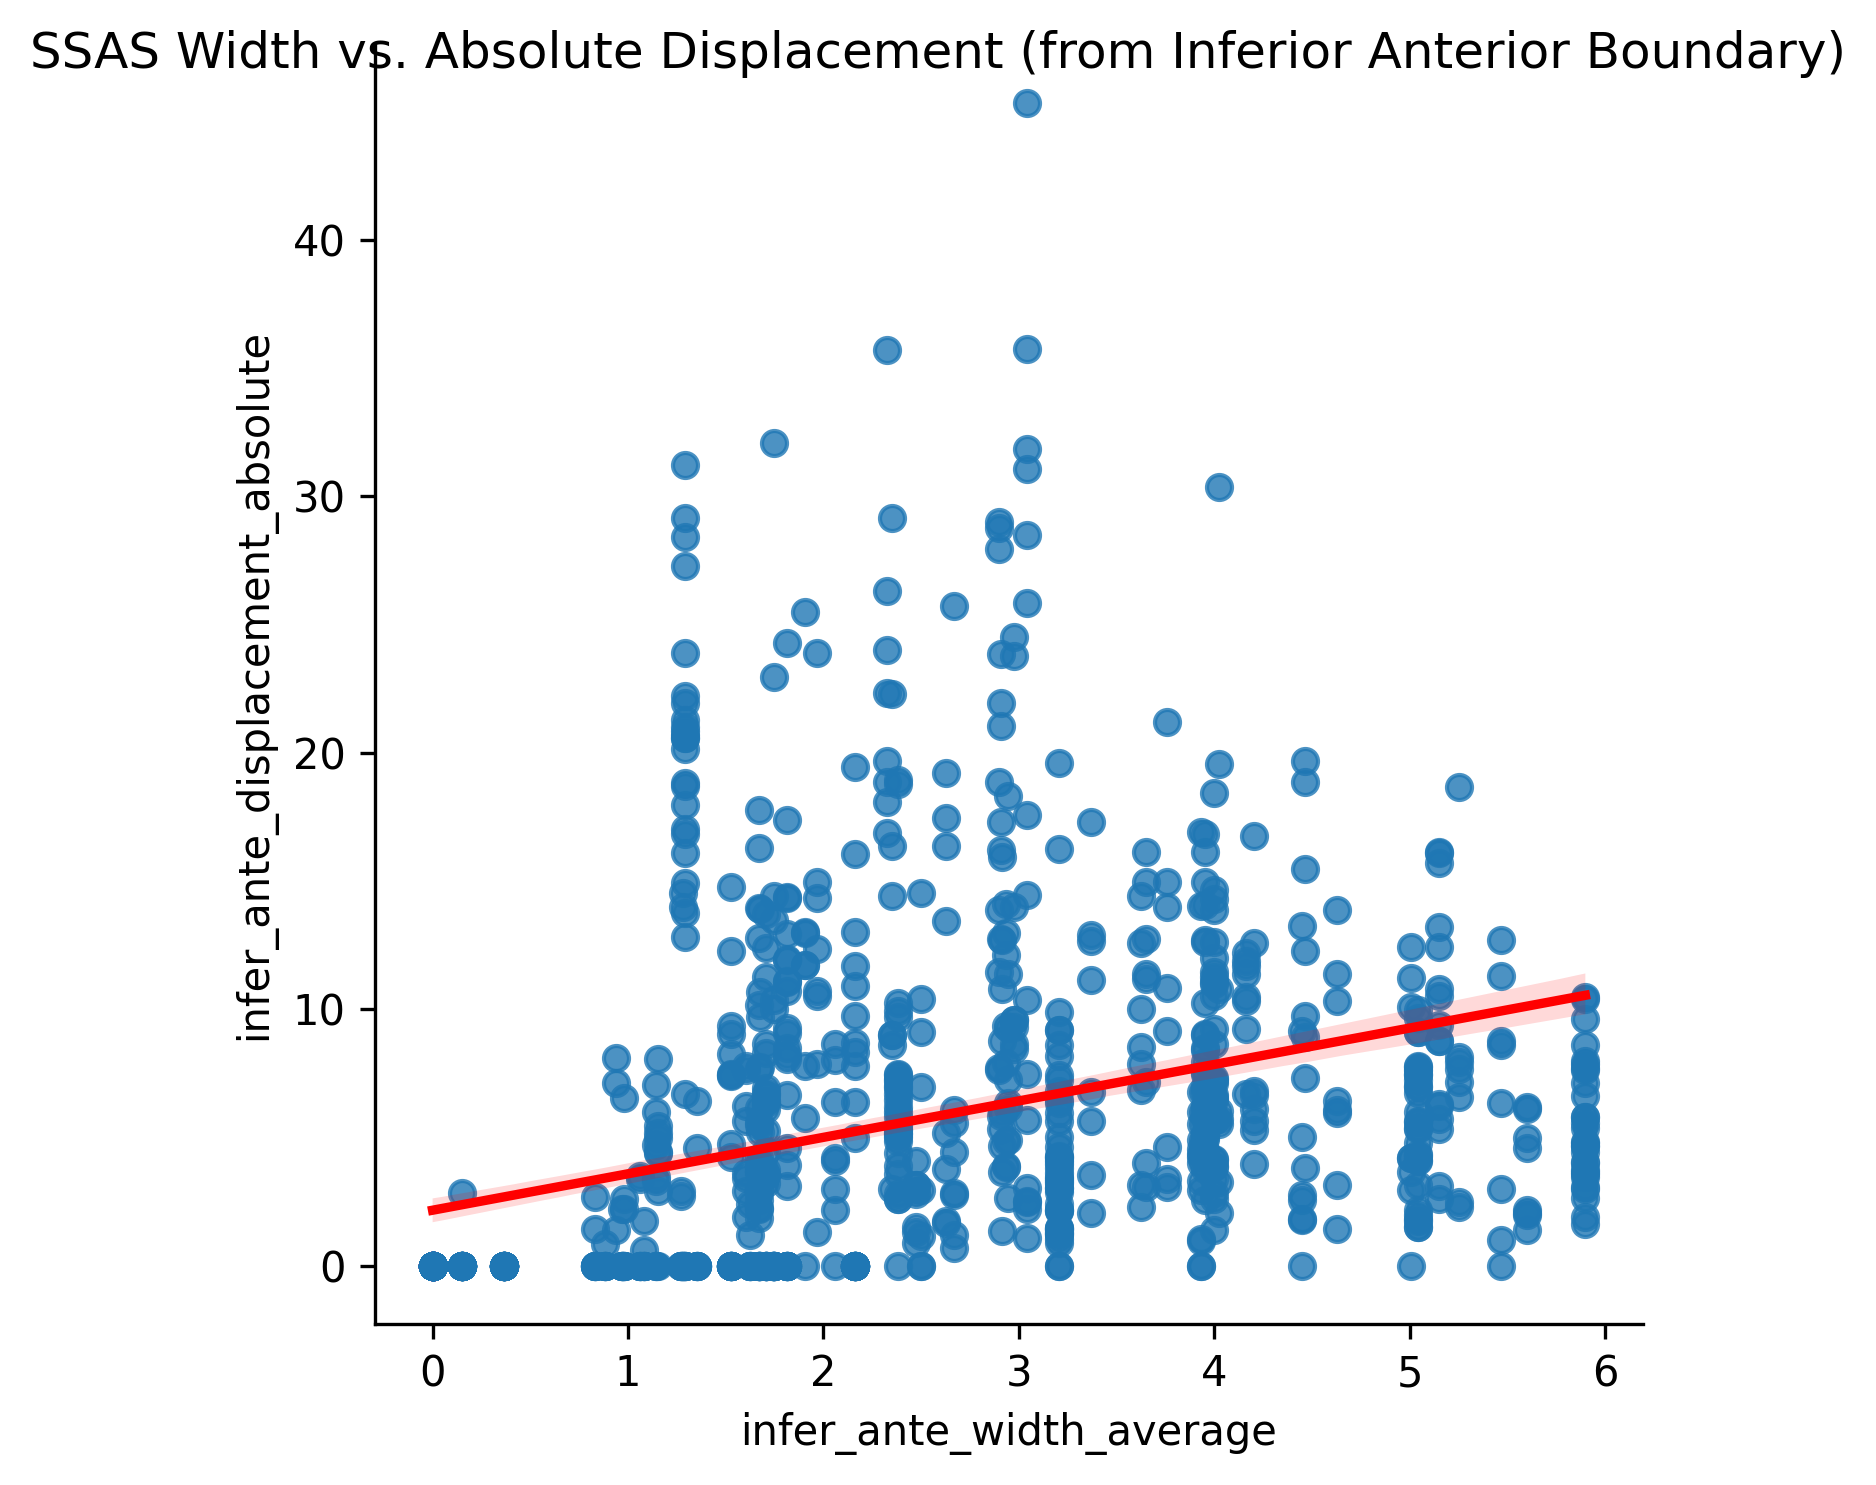

In [37]:
ax = seaborn.lmplot(x="infer_ante_width_average", y="infer_ante_displacement_absolute",
                    data=csf_flow_df, legend=True, line_kws={'color': 'red'})
ax.fig.suptitle("SSAS Width vs. Absolute Displacement (from Inferior Anterior Boundary)")

In [38]:
# Remove columns that need to have real values (not NaN), or else the stats tests break
temp_df = csf_flow_df.copy()
columns_that_cant_be_nan = ['infer_ante_width_average', 'infer_ante_displacement_absolute'] 
temp_df = temp_df.dropna(subset=columns_that_cant_be_nan)

# Pearson Correlation
infer_ante_pearson_abs = stats.pearsonr(temp_df['infer_ante_width_average'], temp_df['infer_ante_displacement_absolute'])
infer_ante_pearson_abs

PearsonRResult(statistic=0.35958575948433547, pvalue=5.580475629085345e-32)

In [39]:
infer_ante_pearson_abs.confidence_interval()

ConfidenceInterval(low=0.3044623593283479, high=0.4123086677189961)

### Inferior Posterior Boundary (Absolute)

Text(0.5, 0.98, 'SSAS Width vs. Absolute Displacement (from Inferior Posterior Boundary)')

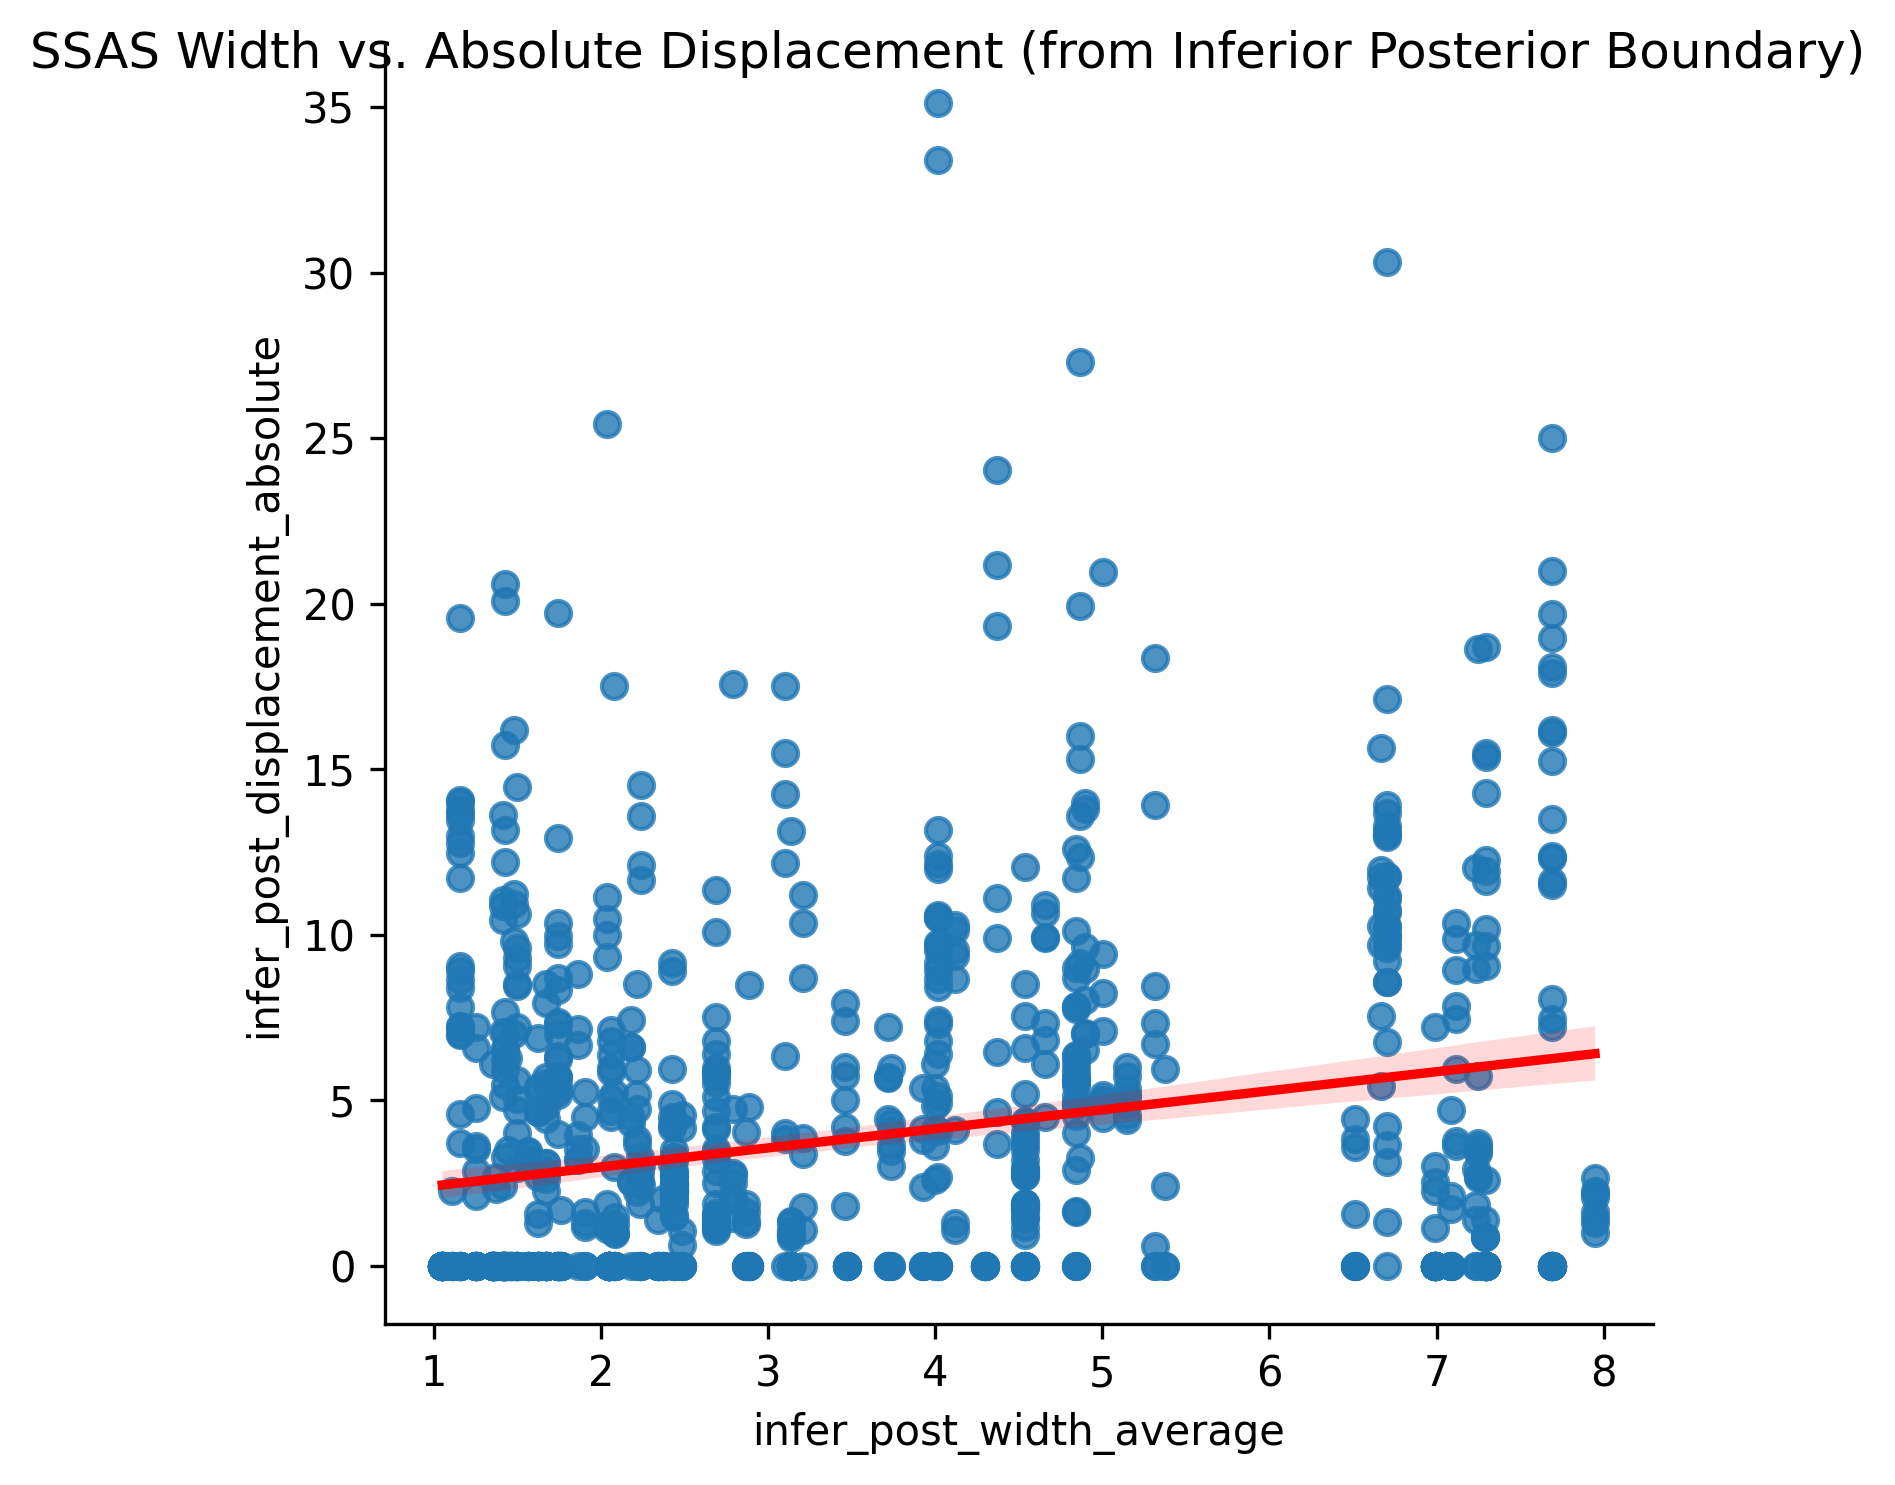

In [40]:
ax = seaborn.lmplot(x="infer_post_width_average", y="infer_post_displacement_absolute",
                    data=csf_flow_df, legend=True, line_kws={'color': 'red'})
ax.fig.suptitle("SSAS Width vs. Absolute Displacement (from Inferior Posterior Boundary)")

In [41]:
# Remove columns that need to have real values (not NaN), or else the stats tests break
temp_df = csf_flow_df.copy()
columns_that_cant_be_nan = ['infer_post_width_average', 'infer_post_displacement_absolute'] 
temp_df = temp_df.dropna(subset=columns_that_cant_be_nan)

# Pearson Correlation
infer_post_pearson_abs = stats.pearsonr(temp_df['infer_post_width_average'], temp_df['infer_post_displacement_absolute'])
infer_post_pearson_abs

PearsonRResult(statistic=0.23806380723850037, pvalue=1.431680025807232e-14)

In [42]:
infer_post_pearson_abs.confidence_interval()

ConfidenceInterval(low=0.17921395227191345, high=0.295216042694081)

### All Boundaries (Absolute)

In [43]:
# Extract all width-displacement combos into 2-column dataframes
super_ante_abs_df = csf_flow_df[['super_ante_width_average', 'super_ante_displacement_absolute']]
super_post_abs_df = csf_flow_df[['super_post_width_average', 'super_post_displacement_absolute']]
infer_ante_abs_df = csf_flow_df[['infer_ante_width_average', 'infer_ante_displacement_absolute']]
infer_post_abs_df = csf_flow_df[['infer_post_width_average', 'infer_post_displacement_absolute']]

# Rename columns for easier combination of dataframes
super_ante_abs_df.columns = ['width', 'absolute_displacement']
super_post_abs_df.columns = ['width', 'absolute_displacement']
infer_ante_abs_df.columns = ['width', 'absolute_displacement']
infer_post_abs_df.columns = ['width', 'absolute_displacement']

In [44]:
# Stack all displacement measurements into one 2-column dataframe
all_measurements_abs = pd.concat([super_ante_abs_df, super_post_abs_df, infer_ante_abs_df, infer_post_abs_df], 
                                             ignore_index=True)
all_measurements_abs.head(3)

width  absolute_displacement
0  4.284875                  3.290
1  4.284875                  3.676
2  4.284875                  4.330

Text(0.5, 0.98, 'SSAS Width vs. Absolute CSF Displacement (All Measurements)')

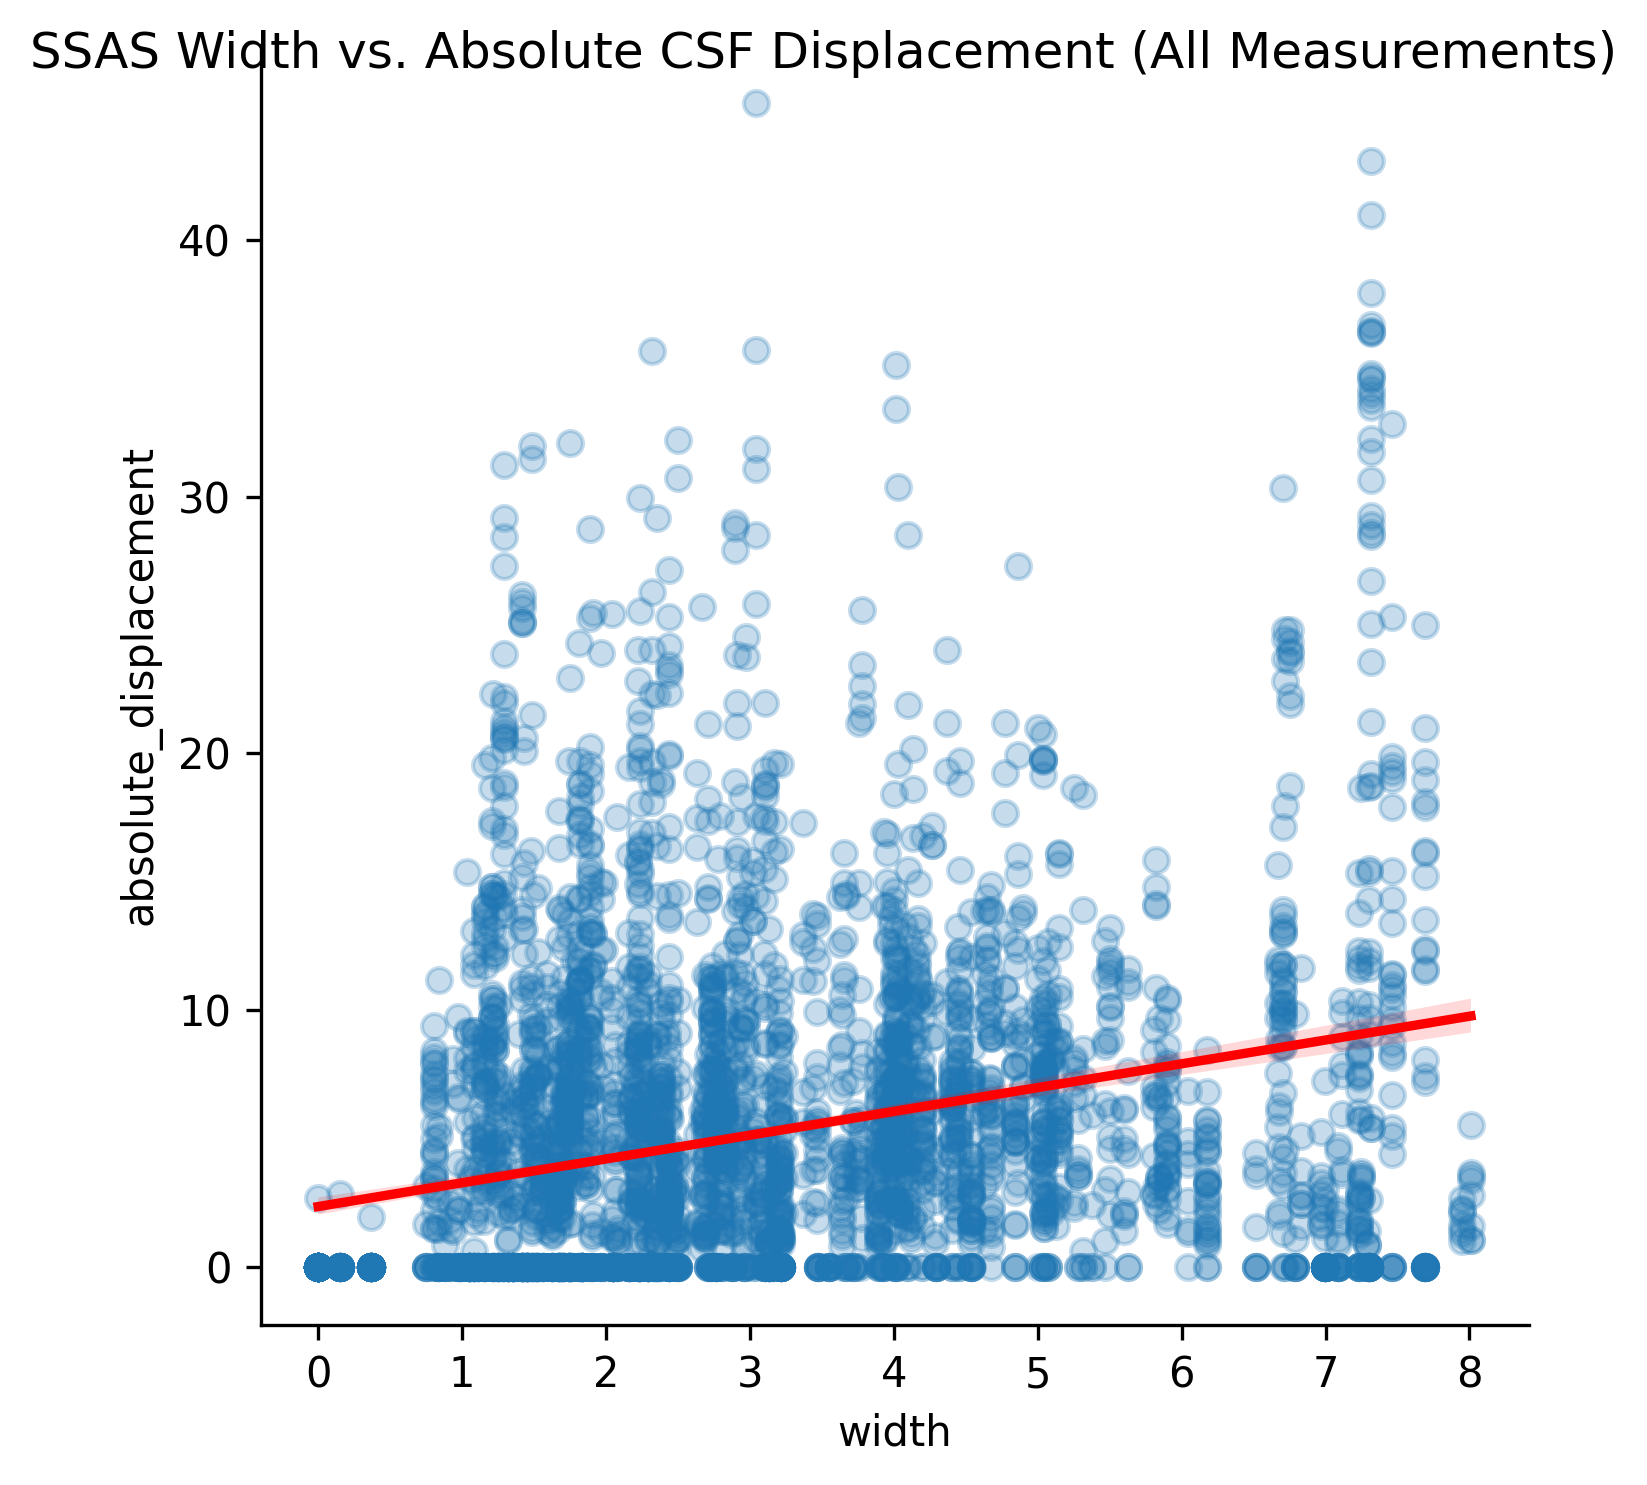

In [45]:
ax = seaborn.lmplot(x="width", y="absolute_displacement",
                    data=all_measurements_abs, legend=True, 
                    line_kws={'color': 'red'}, scatter_kws={'alpha': 0.25})
ax.fig.suptitle("SSAS Width vs. Absolute CSF Displacement (All Measurements)")

In [46]:
all_measurements_abs_no_nan = all_measurements_abs.dropna()
all_measurements_abs_no_nan.shape

(4050, 2)

Linear Regression equation: y = 0.9264944121468727x + 2.3526989621813814


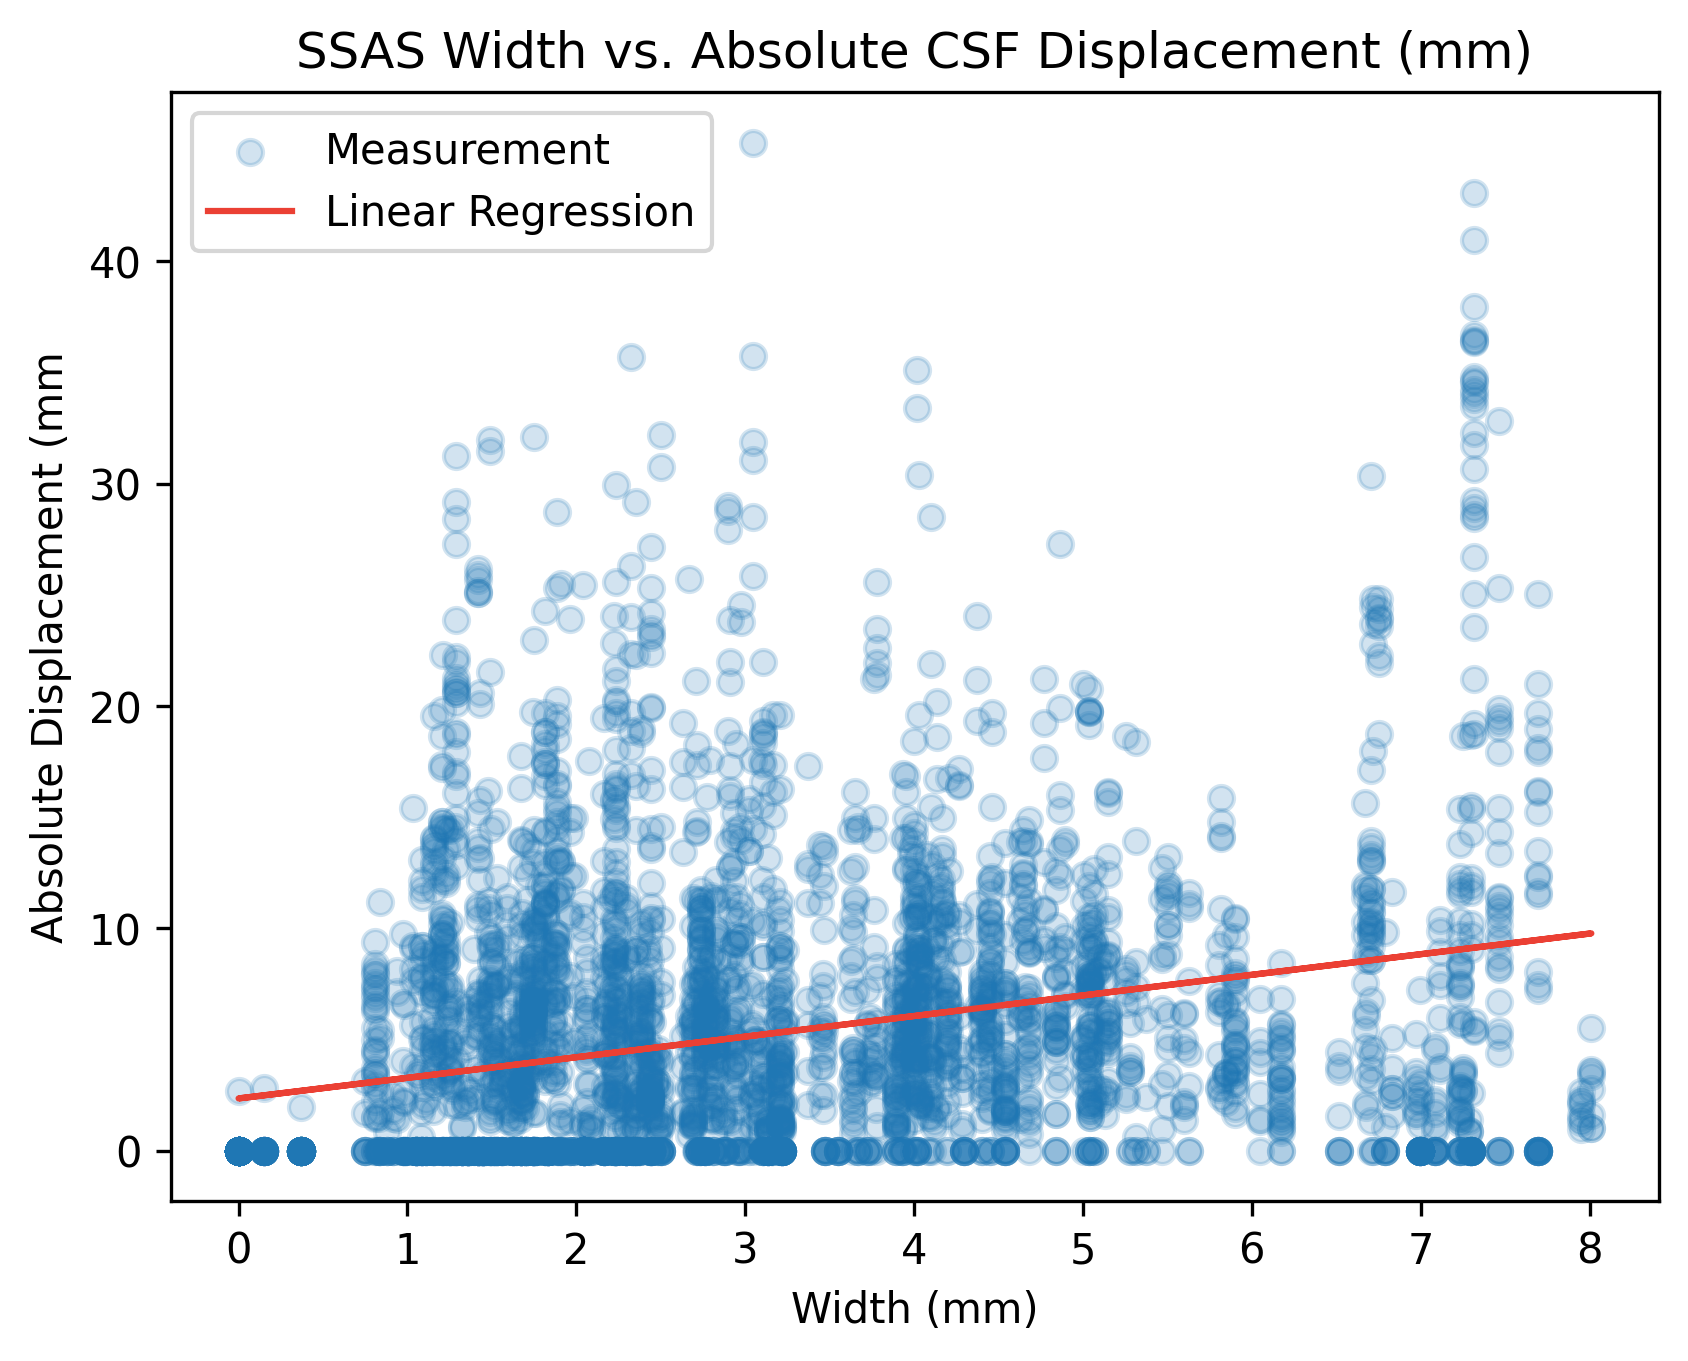

In [47]:
# Create scatter plot with linear regression
x = all_measurements_abs_no_nan['width']
y = all_measurements_abs_no_nan['absolute_displacement']

# Linear regression
m, b = np.polyfit(x, y, deg=1)

plt.scatter(x, y, alpha=0.2, label='Measurement')
plt.plot(x, m*x + b, color='#eb4034', label='Linear Regression')
plt.title('SSAS Width vs. Absolute CSF Displacement (mm)')
plt.xlabel('Width (mm)')
plt.ylabel('Absolute Displacement (mm')
plt.legend()
print(f'Linear Regression equation: y = {m}x + {b}')

In [48]:
x1 = pd.DataFrame(all_measurements_abs_no_nan['width'])
y1 = pd.DataFrame(all_measurements_abs_no_nan['absolute_displacement'])

# Add a constant to the independent variable
x_ = sm.add_constant(x1)

# Fit the linear regression model
model = sm.OLS(y1, x_)
results = model.fit()

# Calculate the confidence intervals
conf_int = results.conf_int(alpha=0.05) # 95% confidence interval

# Print the results
print(conf_int)

              0         1
const  2.024479  2.680919
width  0.831726  1.021262


In [49]:
# Pearson Correlation
df = all_measurements_abs_no_nan
all_measurements_abs_pearson = stats.pearsonr(df['width'], df['absolute_displacement'])
all_measurements_abs_pearson

PearsonRResult(statistic=0.2884526877304951, pvalue=1.8884070389694502e-78)

In [50]:
# 95% confidence interval for Pearson correlation
all_measurements_abs_pearson.confidence_interval()

ConfidenceInterval(low=0.2599627192412038, high=0.31644089240626383)

## Sklearn Linear Regression on SSAS Widths vs. Magnitude of Flow

In the interest of replicability, another popular machine learning library, `scikit-learn`, is used to perform linear regressions.

In [51]:
temp_df = csf_flow_df.copy()[['super_ante_width_average', 'super_ante_displacement_absolute']]
temp_df.dropna(inplace=True)
linear_reg = LinearRegression()

x = pd.DataFrame(temp_df['super_ante_width_average'])
y = pd.DataFrame(temp_df['super_ante_displacement_absolute'])
linear_reg.fit(x, y)

LinearRegression()

Coefficient: [[0.89450501]]
Intercept: [2.66042632]


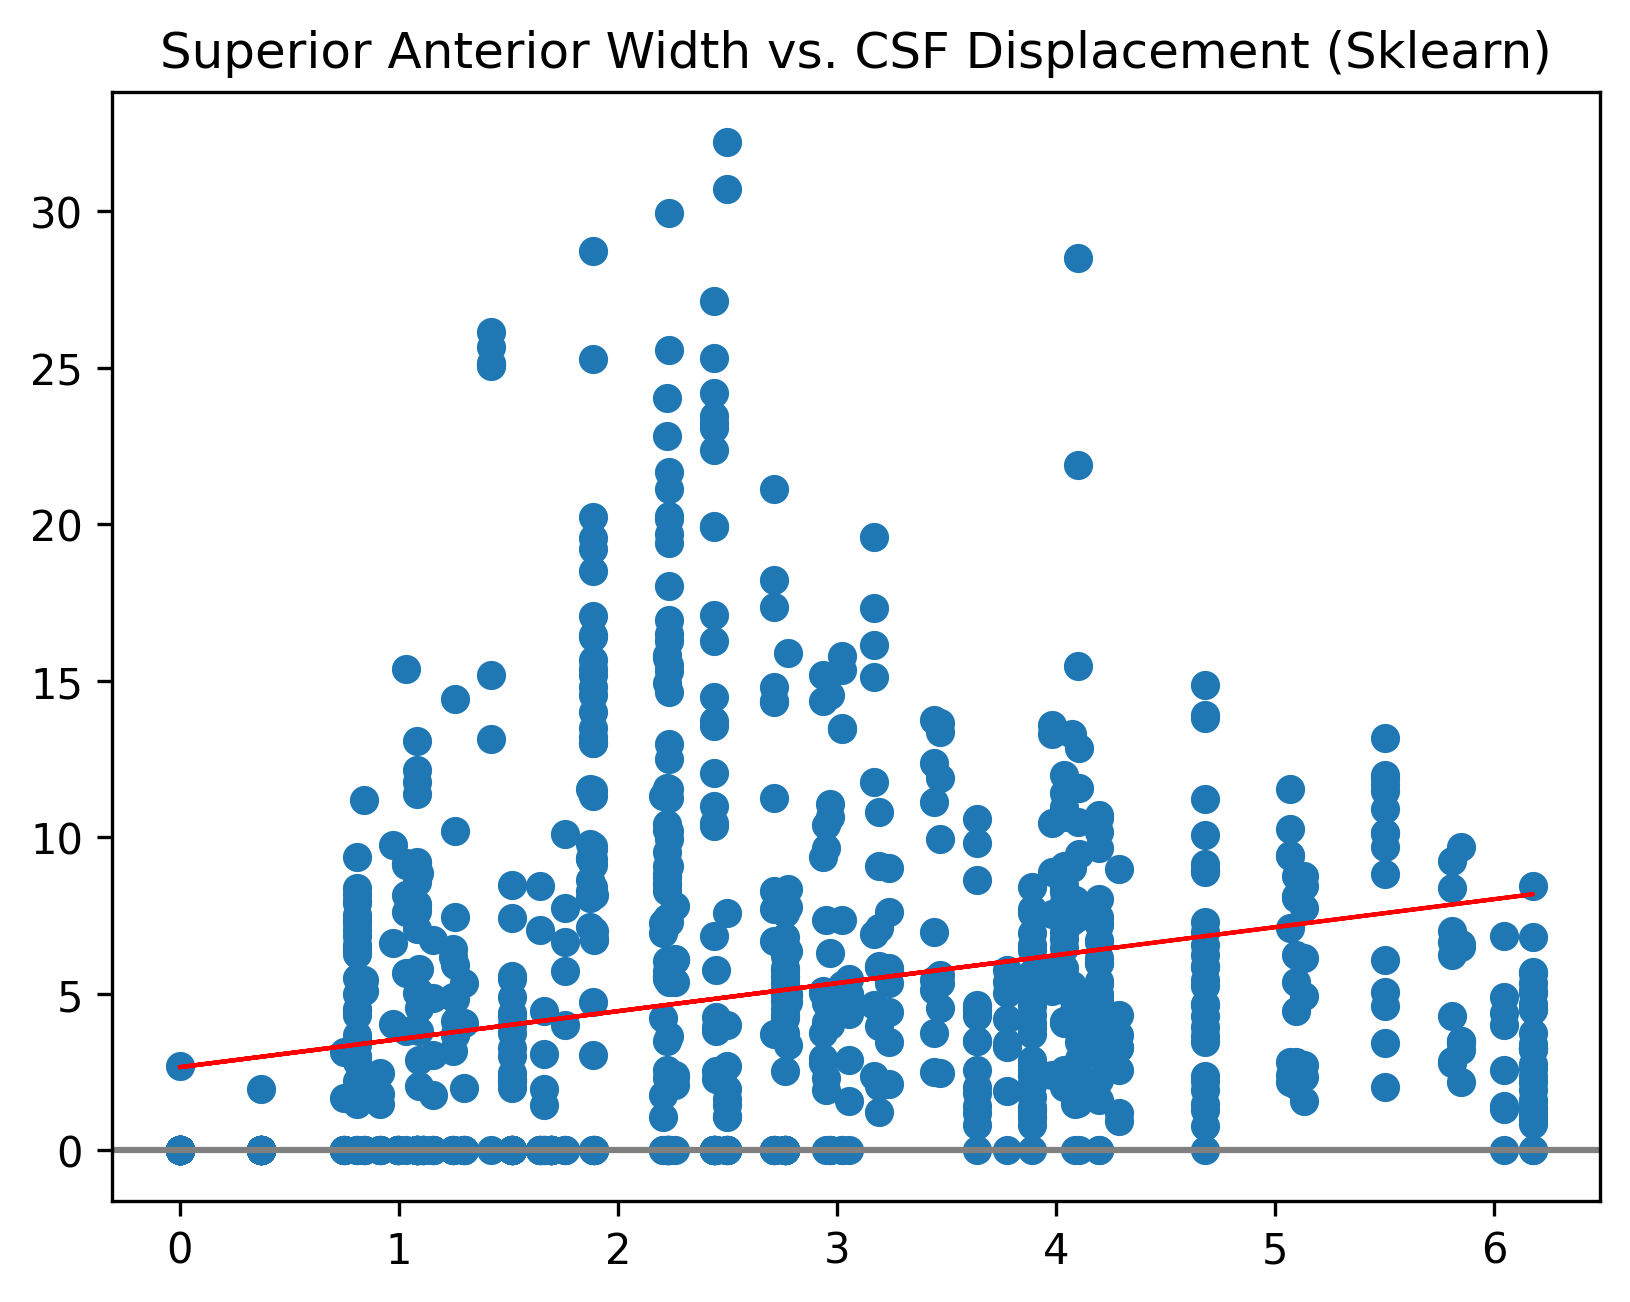

In [52]:
plt.scatter(x, y)
plt.plot(
    x,
    linear_reg.coef_ * x + linear_reg.intercept_,
    label="Linear Regression Model",
    linewidth=1,
    color='red'
)
plt.axhline(0, color="0.5")
plt.title('Superior Anterior Width vs. CSF Displacement (Sklearn)')
print(f'Coefficient: {linear_reg.coef_}')
print(f'Intercept: {linear_reg.intercept_}')

Coefficient: [[1.19827139]]
Intercept: [1.67933273]


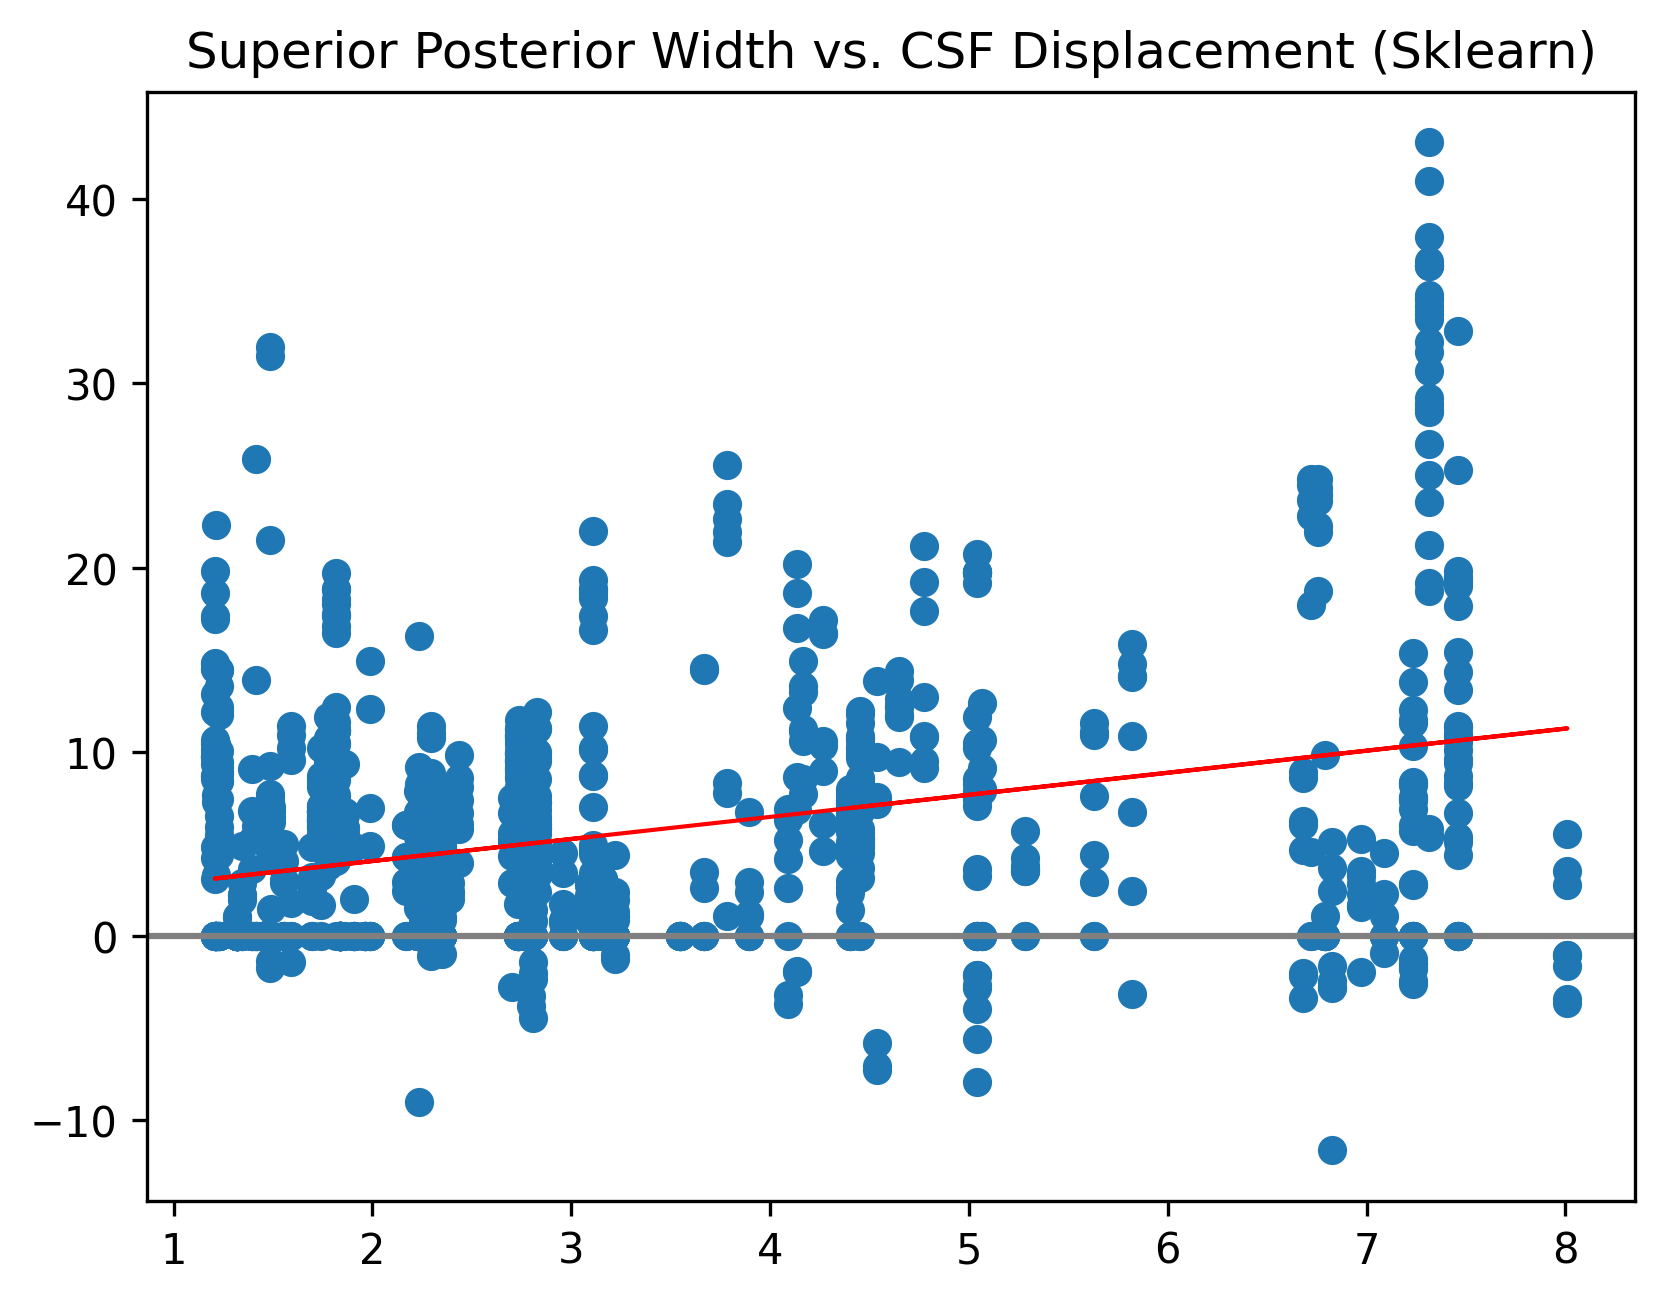

In [53]:
linear_reg = LinearRegression()

x = pd.DataFrame(csf_flow_df['super_post_width_average'])
y = pd.DataFrame(csf_flow_df['super_post_displacement'])

# Drop NaN values from both X and Y before running linear regression
x = x[(x['super_post_width_average'].notna()) & (y['super_post_displacement'].notna())]
y = y[(x['super_post_width_average'].notna()) & (y['super_post_displacement'].notna())]

linear_reg.fit(x, y)

plt.scatter(x, y)
plt.plot(
    x,
    linear_reg.coef_ * x + linear_reg.intercept_,
    label="Linear Regression Model",
    linewidth=1,
    color='red'
)
plt.axhline(0, color="0.5")
plt.title('Superior Posterior Width vs. CSF Displacement (Sklearn)')
print(f'Coefficient: {linear_reg.coef_}')
print(f'Intercept: {linear_reg.intercept_}')

Coefficient: [[-0.82032421]]
Intercept: [-2.39418537]


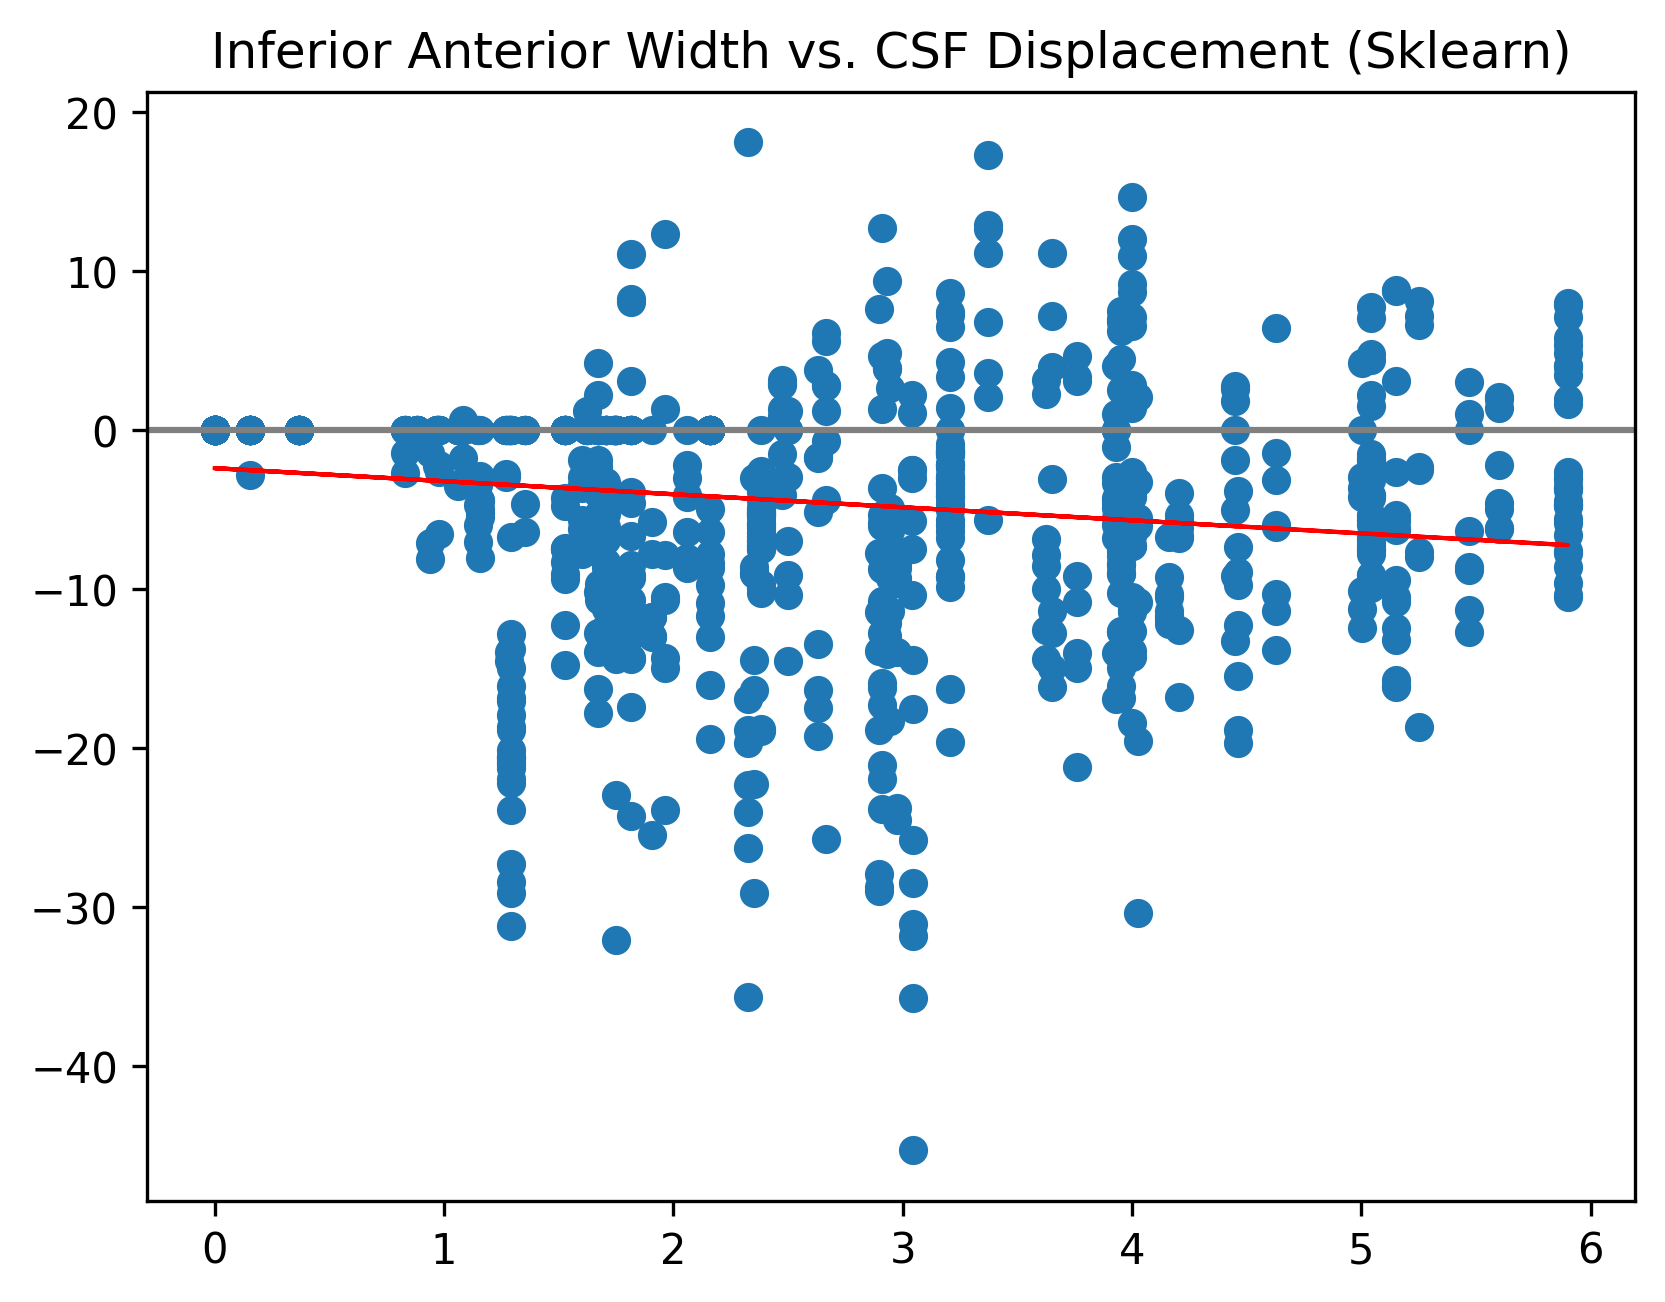

In [54]:
linear_reg = LinearRegression()

x = pd.DataFrame(csf_flow_df['infer_ante_width_average'])
y = pd.DataFrame(csf_flow_df['infer_ante_displacement'])

# Drop NaN values from both X and Y before running linear regression
x = x[(x['infer_ante_width_average'].notna()) & (y['infer_ante_displacement'].notna())]
y = y[(x['infer_ante_width_average'].notna()) & (y['infer_ante_displacement'].notna())]

linear_reg.fit(x, y)

plt.scatter(x, y)
plt.plot(
    x,
    linear_reg.coef_ * x + linear_reg.intercept_,
    label="Linear Regression Model",
    linewidth=1,
    color='red'
)
plt.axhline(0, color="0.5")
plt.title('Inferior Anterior Width vs. CSF Displacement (Sklearn)')
print(f'Coefficient: {linear_reg.coef_}')
print(f'Intercept: {linear_reg.intercept_}')

Coefficient: [[-0.47577961]]
Intercept: [-1.54855603]


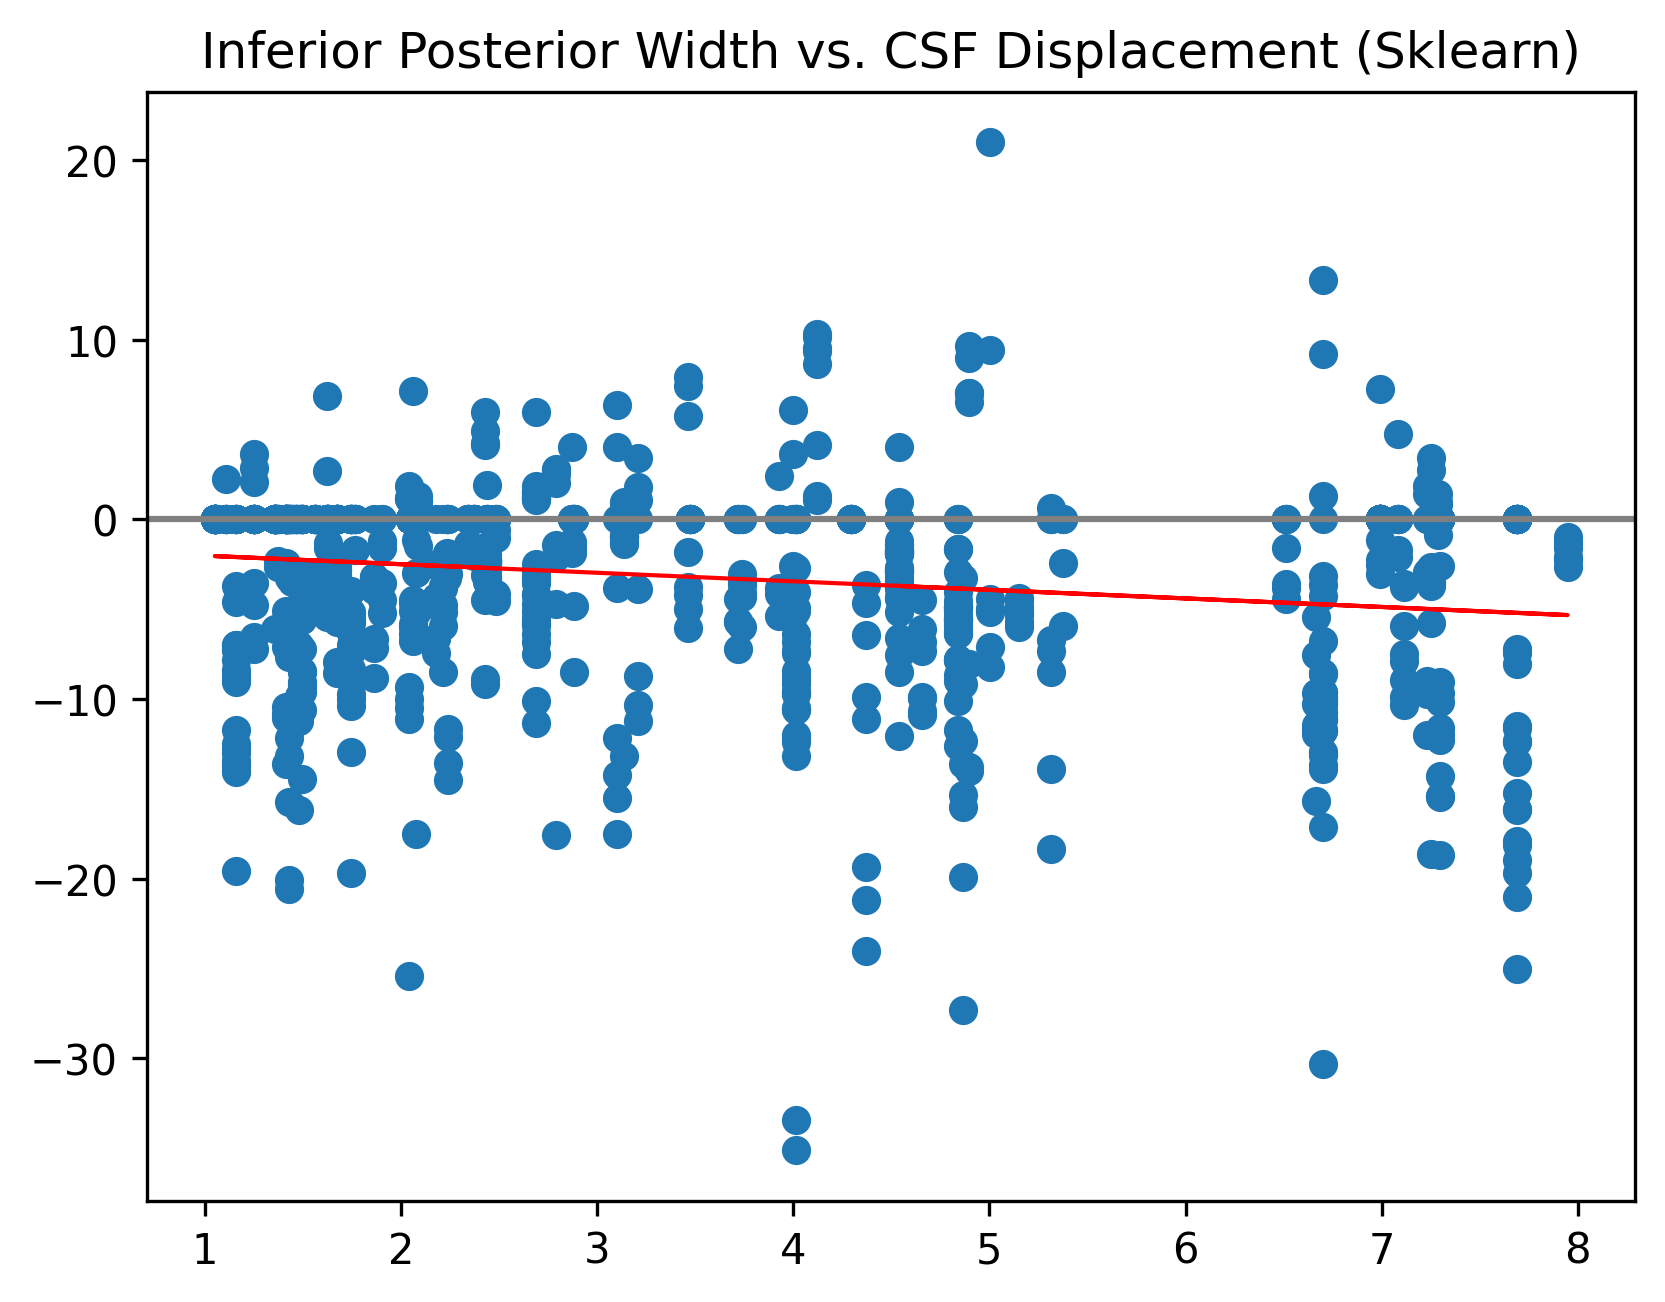

In [55]:
linear_reg = LinearRegression()

x = pd.DataFrame(csf_flow_df['infer_post_width_average'])
y = pd.DataFrame(csf_flow_df['infer_post_displacement'])

# Drop NaN values from both X and Y before running linear regression
x = x[(x['infer_post_width_average'].notna()) & (y['infer_post_displacement'].notna())]
y = y[(x['infer_post_width_average'].notna()) & (y['infer_post_displacement'].notna())]

linear_reg.fit(x, y)

plt.scatter(x, y)
plt.plot(
    x,
    linear_reg.coef_ * x + linear_reg.intercept_,
    label="Linear Regression Model",
    linewidth=1,
    color='red'
)
plt.axhline(0, color="0.5")
plt.title('Inferior Posterior Width vs. CSF Displacement (Sklearn)')
print(f'Coefficient: {linear_reg.coef_}')
print(f'Intercept: {linear_reg.intercept_}')

## Sklearn Linear Regression on SSAS Widths vs. Absolute Magnitude of Flow

Coefficient: [[0.89450501]]
Intercept: [2.66042632]


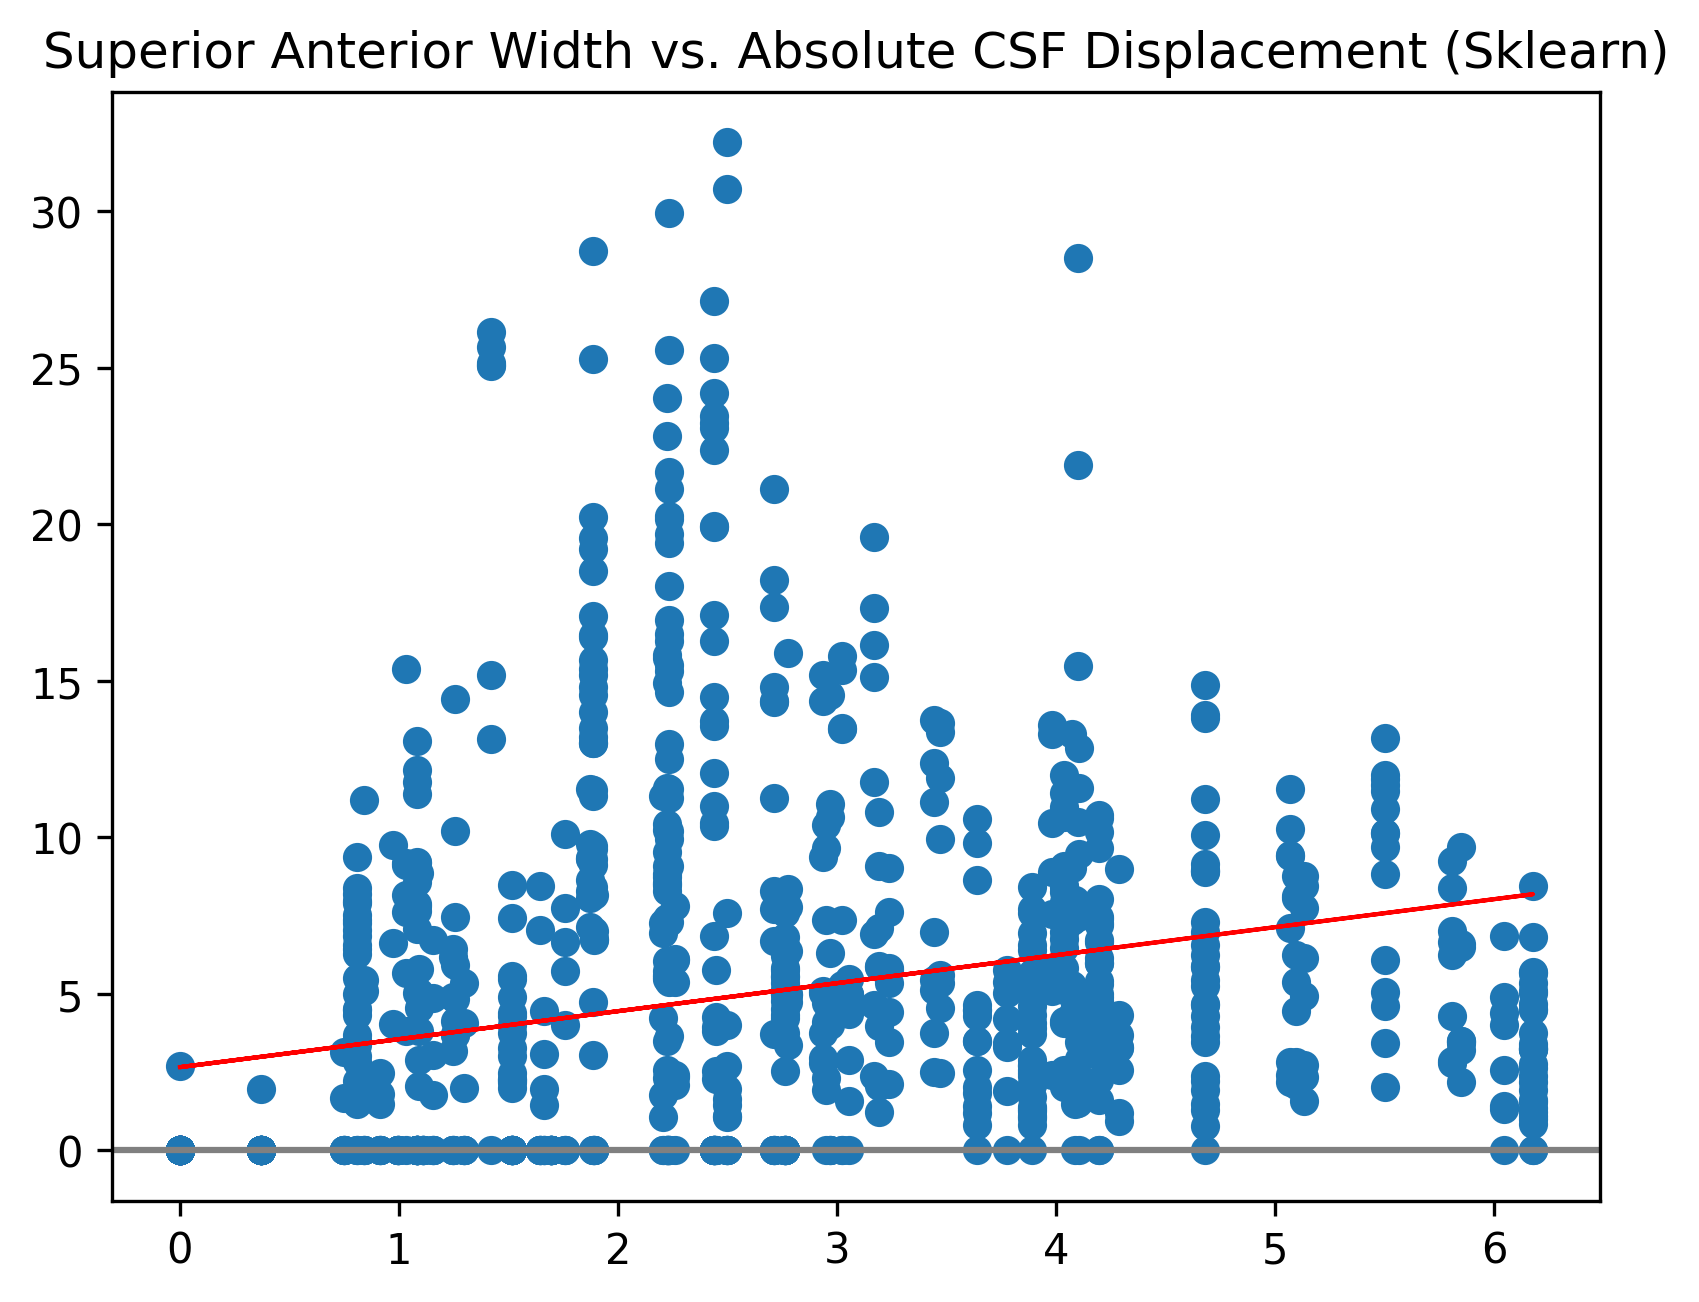

In [56]:
linear_reg = LinearRegression()

x = pd.DataFrame(csf_flow_df['super_ante_width_average'])
y = pd.DataFrame(csf_flow_df['super_ante_displacement_absolute'])

# Drop NaN values from both X and Y before running linear regression
x = x[(x['super_ante_width_average'].notna()) & (y['super_ante_displacement_absolute'].notna())]
y = y[(x['super_ante_width_average'].notna()) & (y['super_ante_displacement_absolute'].notna())]

linear_reg.fit(x, y)

plt.scatter(x, y)
plt.plot(
    x,
    linear_reg.coef_ * x + linear_reg.intercept_,
    label="Linear Regression Model",
    linewidth=1,
    color='red'
)
plt.axhline(0, color="0.5")
plt.title('Superior Anterior Width vs. Absolute CSF Displacement (Sklearn)')
print(f'Coefficient: {linear_reg.coef_}')
print(f'Intercept: {linear_reg.intercept_}')

Coefficient: [[1.32961952]]
Intercept: [1.53728575]


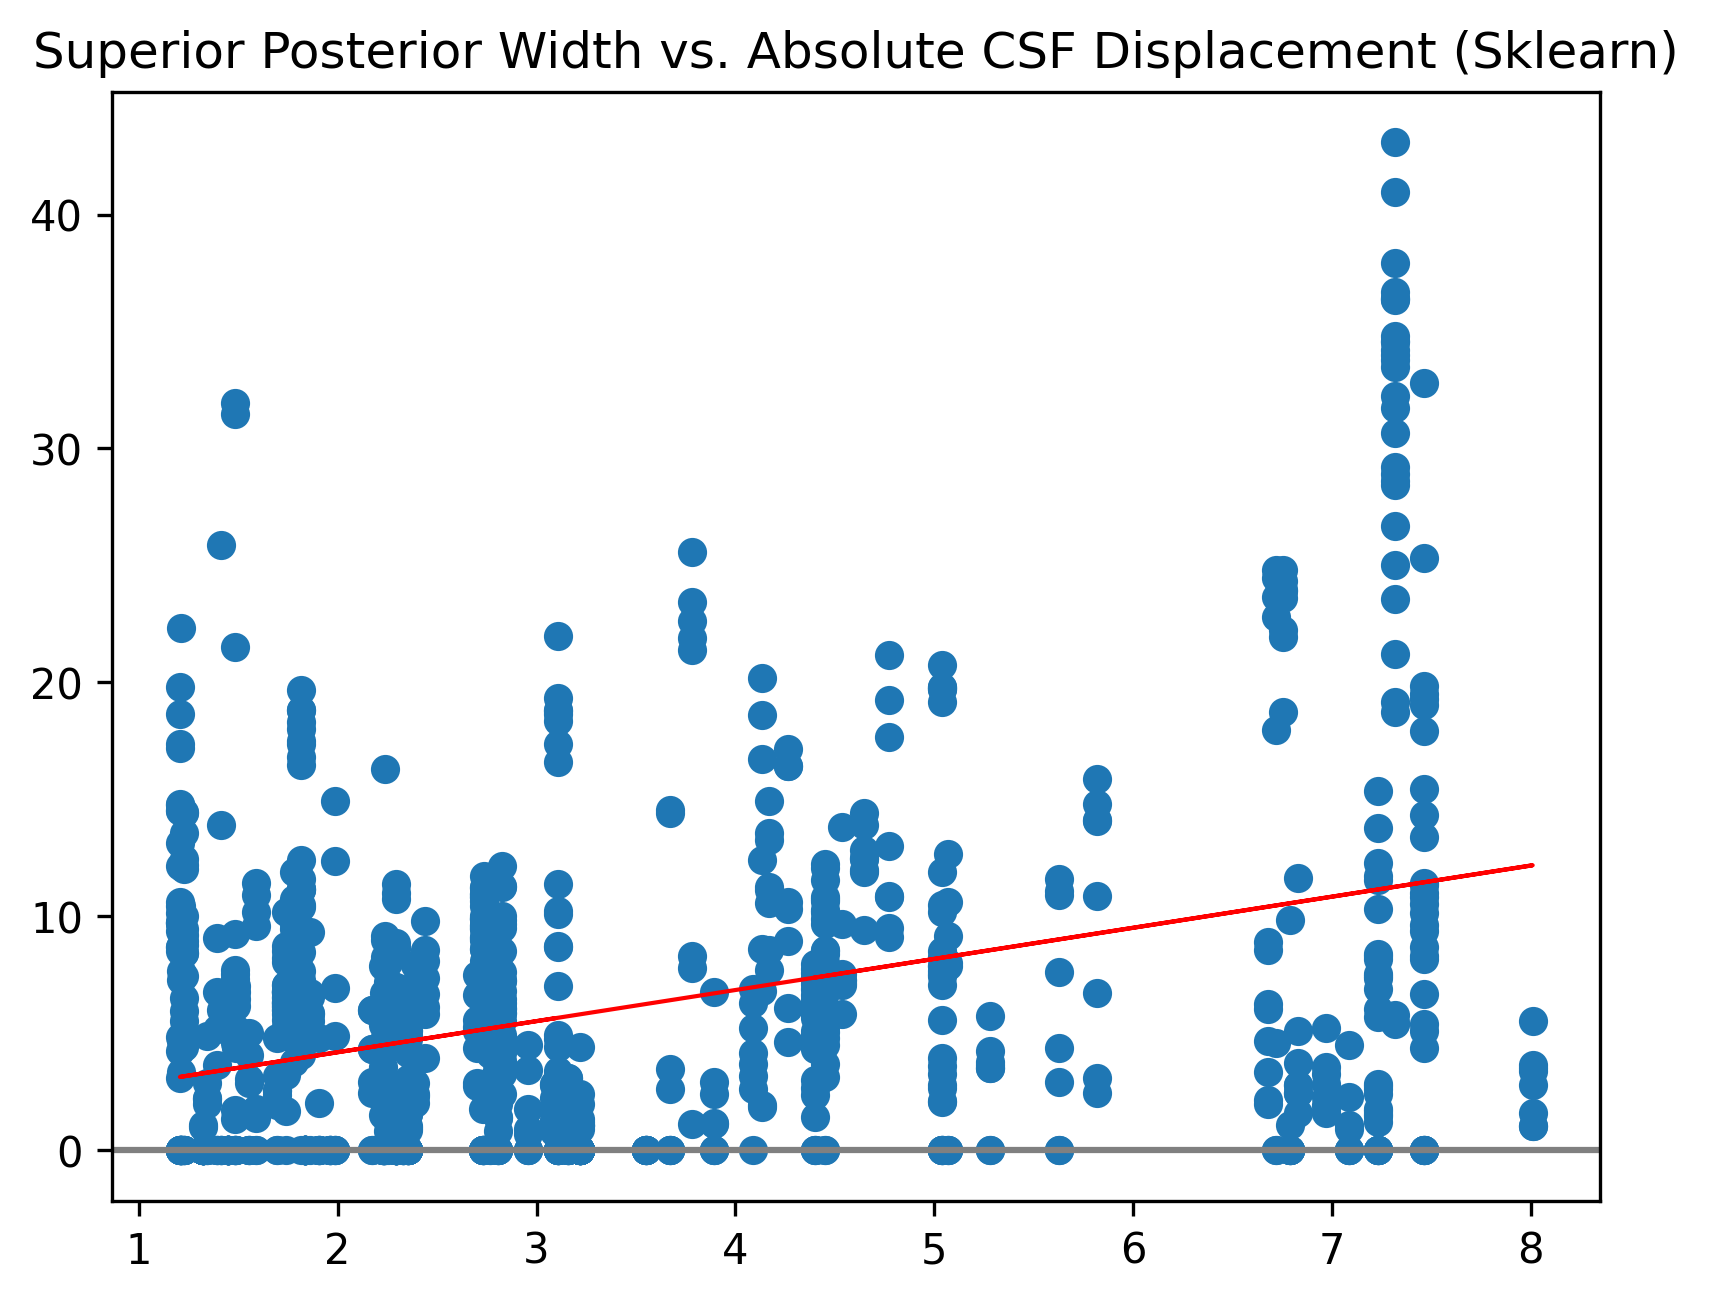

In [57]:
linear_reg = LinearRegression()

x = pd.DataFrame(csf_flow_df['super_post_width_average'])
y = pd.DataFrame(csf_flow_df['super_post_displacement_absolute'])

# Drop NaN values from both X and Y before running linear regression
x = x[(x['super_post_width_average'].notna()) & (y['super_post_displacement_absolute'].notna())]
y = y[(x['super_post_width_average'].notna()) & (y['super_post_displacement_absolute'].notna())]

linear_reg.fit(x, y)

plt.scatter(x, y)
plt.plot(
    x,
    linear_reg.coef_ * x + linear_reg.intercept_,
    label="Linear Regression Model",
    linewidth=1,
    color='red'
)
plt.axhline(0, color="0.5")
plt.title('Superior Posterior Width vs. Absolute CSF Displacement (Sklearn)')
print(f'Coefficient: {linear_reg.coef_}')
print(f'Intercept: {linear_reg.intercept_}')

Coefficient: [[1.41995875]]
Intercept: [2.17486075]


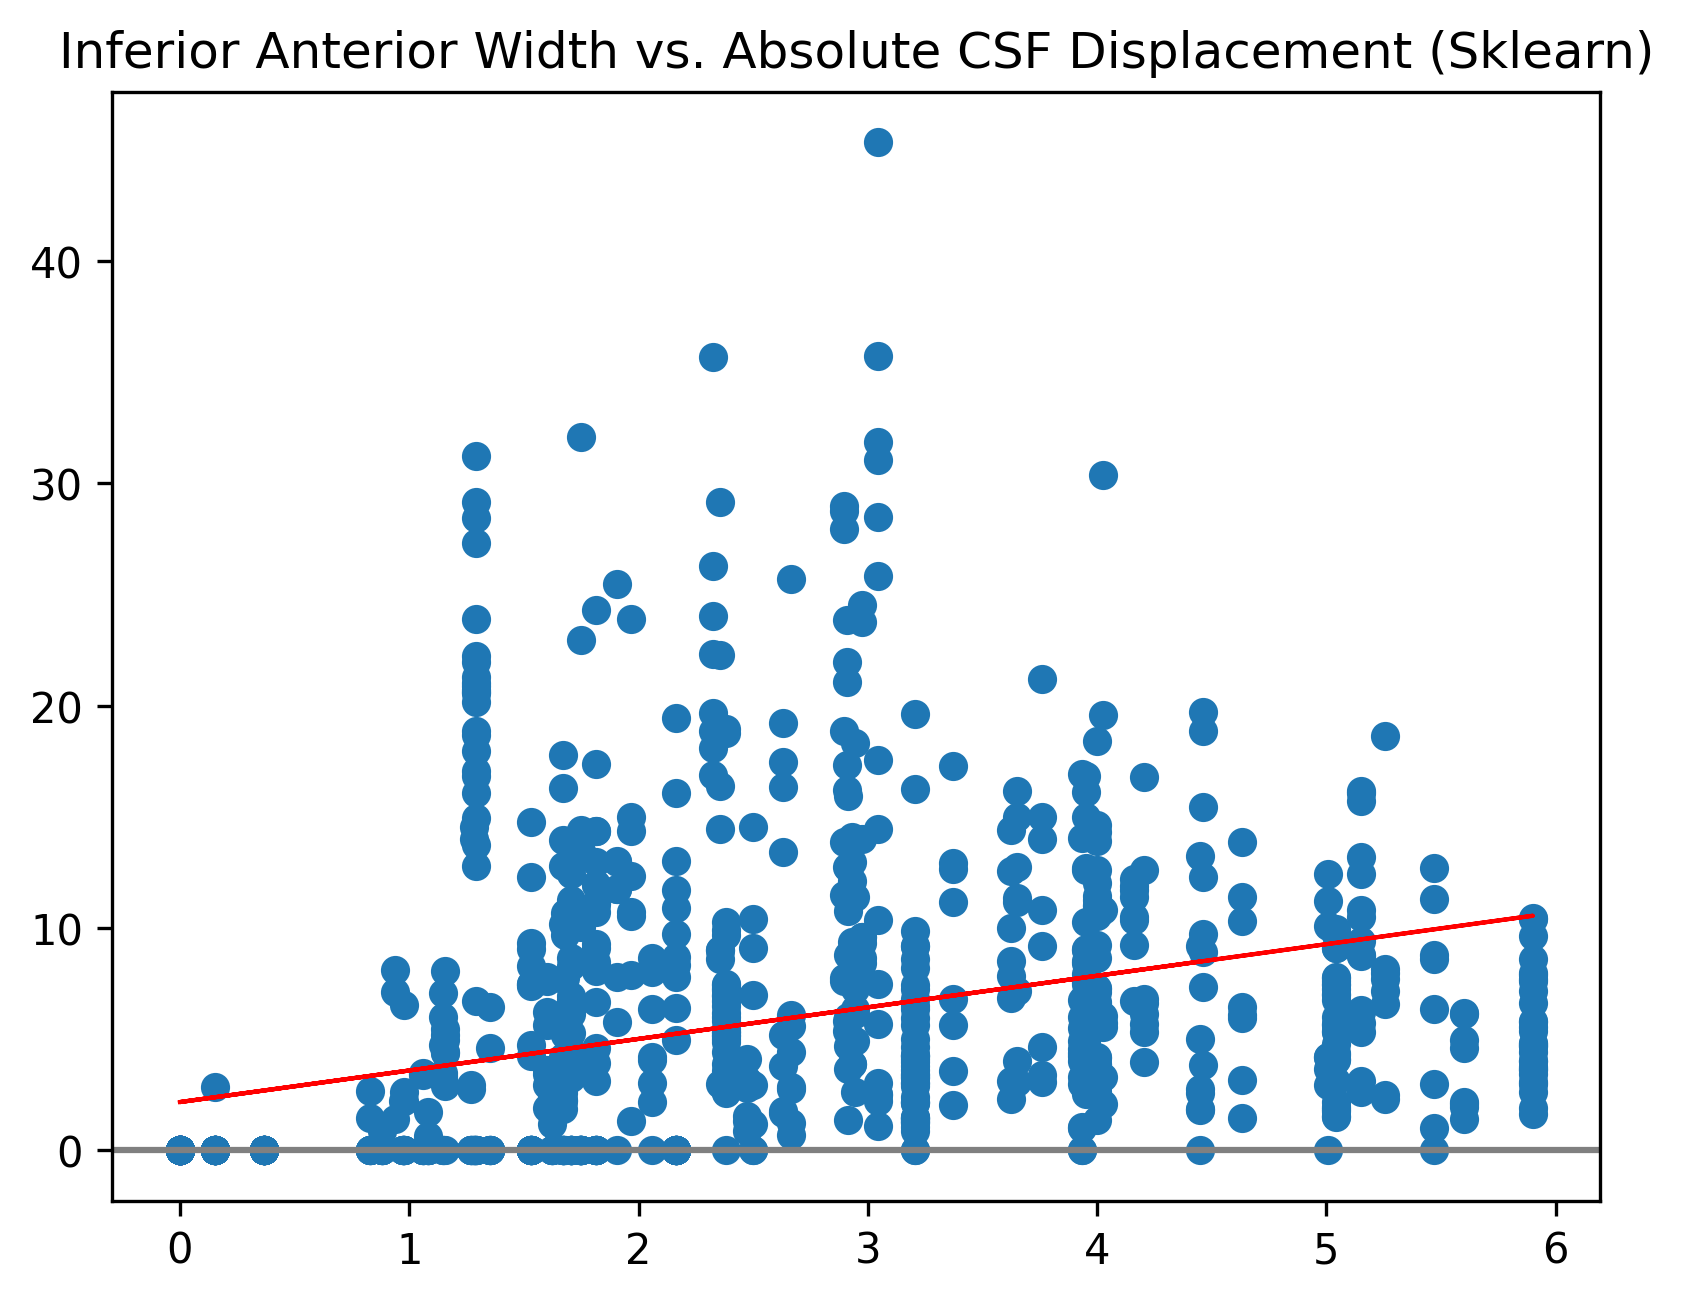

In [58]:
linear_reg = LinearRegression()

x = pd.DataFrame(csf_flow_df['infer_ante_width_average'])
y = pd.DataFrame(csf_flow_df['infer_ante_displacement_absolute'])

# Drop NaN values from both X and Y before running linear regression
x = x[(x['infer_ante_width_average'].notna()) & (y['infer_ante_displacement_absolute'].notna())]
y = y[(x['infer_ante_width_average'].notna()) & (y['infer_ante_displacement_absolute'].notna())]

linear_reg.fit(x, y)

plt.scatter(x, y)
plt.plot(
    x,
    linear_reg.coef_ * x + linear_reg.intercept_,
    label="Linear Regression Model",
    linewidth=1,
    color='red'
)
plt.axhline(0, color="0.5")
plt.title('Inferior Anterior Width vs. Absolute CSF Displacement (Sklearn)')
print(f'Coefficient: {linear_reg.coef_}')
print(f'Intercept: {linear_reg.intercept_}')

Coefficient: [[0.57510185]]
Intercept: [1.84232994]


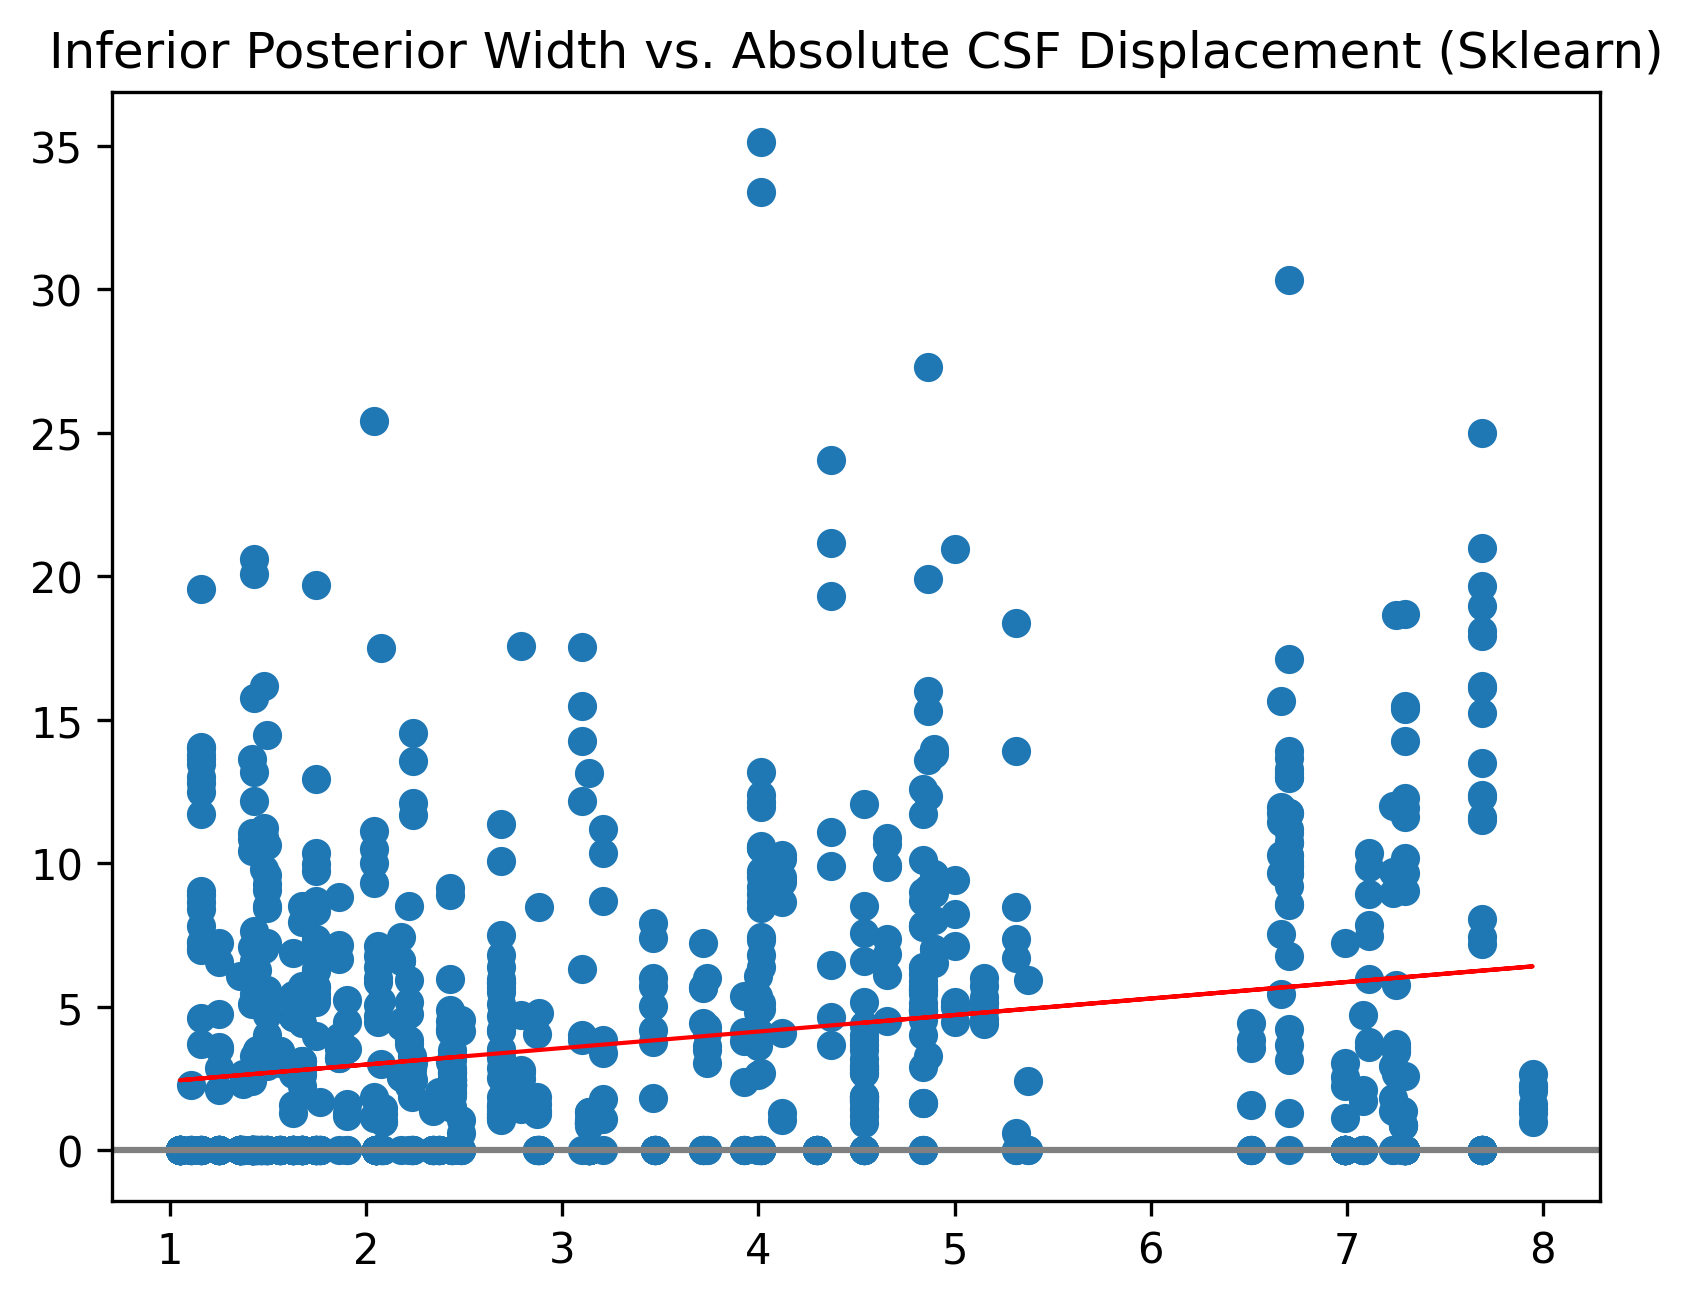

In [59]:
linear_reg = LinearRegression()

x = pd.DataFrame(csf_flow_df['infer_post_width_average'])
y = pd.DataFrame(csf_flow_df['infer_post_displacement_absolute'])

# Drop NaN values from both X and Y before running linear regression
x = x[(x['infer_post_width_average'].notna()) & (y['infer_post_displacement_absolute'].notna())]
y = y[(x['infer_post_width_average'].notna()) & (y['infer_post_displacement_absolute'].notna())]

linear_reg.fit(x, y)

plt.scatter(x, y)
plt.plot(
    x,
    linear_reg.coef_ * x + linear_reg.intercept_,
    label="Linear Regression Model",
    linewidth=1,
    color='red'
)
plt.axhline(0, color="0.5")
plt.title('Inferior Posterior Width vs. Absolute CSF Displacement (Sklearn)')
print(f'Coefficient: {linear_reg.coef_}')
print(f'Intercept: {linear_reg.intercept_}')

## Contra- or Ipsi-directionality (Chi-square Test)

In [60]:
csf_flow_df.head()

patient_id  age spinal_region image_group image_number  \
0          2   24          C2-3           1            1   
1          2   24          C2-3           1            2   
2          2   24          C2-3           1            3   
3          2   24          C2-3           1            4   
4          2   24          C2-3           1            5   

   foramen_magnum_distance  super_ante_displacement  infer_ante_displacement  \
0                      NaN                   -3.290                   -5.020   
1                      NaN                    3.676                    1.808   
2                      NaN                   -4.330                   -9.174   
3                      NaN                    1.194                    0.000   
4                      NaN                    2.585                    2.580   

   super_post_displacement  infer_post_displacement  ...  post_qual_direction  \
0                    2.260                   -1.067  ...              rostral   
1                    1.804                    0.000  ...              rostral   
2                    0.800                   -4.159  ...               caudal   
3                    1.717                    0.000  ...              rostral   
4                    1.173                    0.000  ...              rostral   

   image_quality  super_ante_width_average  super_post_width_average  \
0           high                  4.284875                   3.08675   
1           high                  4.284875                   3.08675   
2           high                  4.284875                   3.08675   
3           high                  4.284875                   3.08675   
4           high                  4.284875                   3.08675   

  infer_ante_width_average infer_post_width_average  \
0                   4.4485                  2.48525   
1                   4.4485                  2.48525   
2                   4.4485                  2.48525   
3                   4.4485                  2.48525   
4                   4.4485                  2.48525   

  super_ante_displacement_absolute  infer_ante_displacement_absolute  \
0                            3.290                             5.020   
1                            3.676                             1.808   
2                            4.330                             9.174   
3                            1.194                             0.000   
4                            2.585                             2.580   

   super_post_displacement_absolute  infer_post_displacement_absolute  
0                             2.260                             1.067  
1                             1.804                             0.000  
2                             0.800                             4.159  
3                             1.717                             0.000  
4                             1.173                             0.000  

[5 rows x 25 columns]

In [61]:
# Cross tabulation of direction of flow from anterior vs. posterior sides
cross_tabulation = pd.crosstab(index=csf_flow_df['ante_qual_direction'], columns=csf_flow_df['post_qual_direction'])
cross_tabulation

post_qual_direction  bidirectional  caudal  none  rostral  unreadable
ante_qual_direction                                                  
bidirectional                   10      14    35       48           5
caudal                          66     106    66      112           1
none                            47      63    19      118           0
rostral                         33      43    84      135           2
unreadable                       3       9     1        7         149

#### It does appear that flow is slightly more likely to be ipsi-directional

Caudal flow on one side was observed with caudal flow on the other side 102 times. Rostral vs. rostral: 116 times. This appears to be at odds with the findings of Coenen et al. (2019), which stated that CSF flow was generally contralateral.

In [62]:
chi_square = stats.chi2_contingency(cross_tabulation)
print(chi_square)
print(f'Chi-square statistic: {chi_square.statistic}')
print(f'p-value: {chi_square.pvalue}')
print(f'p-value < 0.05: {chi_square.pvalue < 0.05}')

Chi2ContingencyResult(statistic=1051.5406670739512, pvalue=1.0228150161170078e-213, dof=16, expected_freq=array([[ 15.14285714,  22.38095238,  19.52380952,  40.        ,
         14.95238095],
       [ 47.45663265,  70.14030612,  61.18622449, 125.35714286,
         46.85969388],
       [ 33.39540816,  49.3579932 ,  43.05697279,  88.21428571,
         32.97534014],
       [ 40.15561224,  59.3494898 ,  51.77295918, 106.07142857,
         39.6505102 ],
       [ 22.8494898 ,  33.7712585 ,  29.46003401,  60.35714286,
         22.56207483]]))
Chi-square statistic: 1051.5406670739512
p-value: 1.0228150161170078e-213
p-value < 0.05: True
